In [1]:
from __future__ import print_function

import os
import sys
sys.path.insert(0, os.path.abspath("../.."))

# IBM PAIRS open-source module
from ibmpairs import paw

import numpy
import pandas
import geopandas
import shapely
from shapely import wkb, wkt
from datetime import datetime, timedelta
import pytz

import statsmodels.api as sm

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
ROLLING_WINDOW=7

dt_cutoff_min = datetime(2020, 3, 5, tzinfo=pytz.utc)
print('Considering data from                      ', dt_cutoff_min)

dt_cutoff_latest = datetime(2020,8,2, tzinfo=pytz.utc)
print('Plotting data up to                        ', dt_cutoff_latest)

data_subdirectory = 'data/csv/run29RW7'
if not os.path.exists(data_subdirectory):
    os.makedirs(data_subdirectory)
print('data_subdirectory                          ', data_subdirectory)

Considering data from                       2020-03-05 00:00:00+00:00
Plotting data up to                         2020-08-02 00:00:00+00:00
data_subdirectory                           data/csv/run29RW7


In [3]:
PAIRS_USER              = ##############
PAIRS_SERVER            = ##############
BASE_URI                = ##############
PAIRS_PASSWORD          = ##############
PAIRS_CREDENTIALS       = ##############

def query_state(layerID, overwriteExisting=True):
    """
    layerID:
    JHU
    state cases:      P568C6015
    state fatalities: P568C6016

    MOBILITY
    state mobility:   P611C6298
    """
    coronaQueryDef = {
        "layers": [
            {"id": layerID},
        ],
        "spatial": {
            "type" :        "square",
            "coordinates" : [-89, -179, 89, 179], 
        },
        "temporal": {
            "intervals": [
                {
                    "start": "2019-03-01T00:00:00Z",
                    "end": "2030-03-10T23:59:59Z"
                }
            ]
        },
        "outputType": "csv"
    }

    # create PAIRS query instance
    coronaQuery = paw.PAIRSQuery(
        coronaQueryDef,
        pairsHost = 'https://'+PAIRS_SERVER,
        auth = PAIRS_CREDENTIALS,
        baseURI = BASE_URI,
        overwriteExisting = overwriteExisting,
    )
    # submit and download modified query
    coronaQuery.submit()
    coronaQuery.poll_till_finished(printStatus=True)
    coronaQuery.download()
    coronaQuery.create_layers()
    
    # associate vector data frame, and show the vector data
    coronaQuery.vdf = coronaQuery.data[list(coronaQuery.metadata.keys())[0]]

    # split property string into individual columns
    #coronaQuery.split_property_string_column()

    new = coronaQuery.vdf['Region'].str.split(':', expand=True)
    coronaQuery.vdf['pairs_id'] = new[0]
    coronaQuery.vdf['State'] = new[1]
    
    return coronaQuery

In [4]:
# State Mobility and Covid Data

# State Mobility
mobilityQueryState = query_state(layerID='P611C6298')
df_state_mobility = mobilityQueryState.vdf[['timestamp', 'pairs_id', 'State', 'Value']]
df_state_mobility = df_state_mobility.rename(columns={'Value': 'Mobility'})
df_state_mobility['pairs_id'] = df_state_mobility['pairs_id'].astype(int)

# Make a copy in the specific subfolder
df_state_mobility.to_csv(os.path.join(data_subdirectory, 'df_state_mobility.csv'), index=None)

# Read back covid data from csv
df_state_mobility = pandas.read_csv(os.path.join(data_subdirectory, 'df_state_mobility.csv'))
df_state_mobility['timestamp'] = pandas.to_datetime(df_state_mobility['timestamp'])
df_state_mobility.tail()

# State Cases
coronaQueryState = query_state(layerID='P568C6015')
df_state_cases = coronaQueryState.vdf[['timestamp', 'pairs_id', 'State', 'Value']]
df_state_cases = df_state_cases.rename(columns={'Value': 'Cases'})
df_state_cases['pairs_id'] = df_state_cases['pairs_id'].astype(int)

# Individual States found in df_region
df_region = df_state_cases[['pairs_id', 'State']].drop_duplicates().reset_index(drop=True)

# We are only interested in USA states so filter by pairs_id
df_region = df_region[(df_region['pairs_id']>=121)&(df_region['pairs_id']<=171)].reset_index(drop=True)
df_state_cases = df_state_cases[(df_state_cases['pairs_id']>=121)&(df_state_cases['pairs_id']<=171)].reset_index(drop=True)

state_pairs_ids = sorted(list(df_region['pairs_id']))

# Make a copy in the specific subfolder
df_state_cases.to_csv(os.path.join(data_subdirectory, 'df_state_cases.csv'), index=None)

# Read back covid data from csv
df_s = pandas.read_csv(os.path.join(data_subdirectory, 'df_state_cases.csv'))
df_s['timestamp'] = pandas.to_datetime(df_s['timestamp'])
df_s.tail()

No handlers could be found for logger "ibmpairs.paw"


timestamp  pairs_id             State  Cases
11725 2020-09-07 00:00:00+00:00       152  USA - New Mexico  26144
11726 2020-09-07 00:00:00+00:00       137      USA - Kansas  46337
11727 2020-09-07 00:00:00+00:00       166     USA - Vermont   1651
11728 2020-09-07 00:00:00+00:00       158      USA - Oregon  28190
11729 2020-09-07 00:00:00+00:00       136        USA - Iowa  70537

In [5]:
# Split country-state names into two columns
country_state = (' - ' + df_region['State']).str.rsplit(' - ', n=1, expand=True)
country_state[0] = country_state[0].str.replace(' - ', '')

df_region['Country'] = country_state[0]
df_region['State'] = country_state[1]

# Make a copy in the specific subfolder
df_region.to_csv(os.path.join(data_subdirectory, 'df_region_STATE.csv'), index=None)

# Read back covid data from csv
df_region = pandas.read_csv(os.path.join(data_subdirectory, 'df_region_STATE.csv'))
df_region.tail()

pairs_id       State Country
46       139   Louisiana     USA
47       167    Virginia     USA
48       121     Alabama     USA
49       152  New Mexico     USA
50       126    Colorado     USA

In [6]:
# Unstacking COVID19 and mobility

# Unstack the COVID19 data and first derivative (new cases)
df_unstacked = df_s.copy()
del df_unstacked['State']

df_unstacked = df_unstacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(by='timestamp').set_index('timestamp')
df_unstacked = df_unstacked.swaplevel(axis=1)
df_unstacked = df_unstacked.replace(0, numpy.nan)

# Replace values where no change with nan so that the daily numbers make sense when reporting only every couple of days
# (also replace values with negative change)
df_unstacked[df_unstacked.diff()<=0] = numpy.nan

# Interpolate
df_unstacked = df_unstacked.interpolate(method='linear', limit_area='inside')

# New Local Cases (1st derivative)
df_new = df_unstacked.diff()


# Unstack the mobility data
df_m_unstacked = df_state_mobility[df_state_mobility['pairs_id'].isin(state_pairs_ids)]
del df_m_unstacked['State']

df_m_unstacked = df_m_unstacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(by='timestamp').set_index('timestamp')
df_m_unstacked = df_m_unstacked.swaplevel(axis=1)

# Erase high-value mobility outliers >100miles before taking the rolling mean
df_m_unstacked = df_m_unstacked.clip(upper=100)

# Interpolate
df_m_unstacked = df_m_unstacked.interpolate(method='linear', limit_area='inside')

df_m_unstacked.tail()


# Stack and merge in order to fill in nan at all missing combinations
df_stacked = pandas.merge(df_new.stack(level='pairs_id').reset_index(),
                          df_m_unstacked.stack(level='pairs_id').reset_index(),
                          on=['timestamp', 'pairs_id'],
                          how='outer'
                         )
df_stacked['pairs_id'] = df_stacked['pairs_id'].astype(int)

# Unstack again
df_stacked = df_stacked.set_index(['timestamp', 'pairs_id']).unstack().reset_index().sort_values(
    by='timestamp').set_index('timestamp')

df_new = df_stacked[['Cases']].swaplevel(axis=1)
df_m_unstacked = df_stacked[['Mobility']].swaplevel(axis=1)

df_new.tail()

pairs_id                      121    122     123     124     125    126  \
                            Cases  Cases   Cases   Cases   Cases  Cases   
timestamp                                                                 
2020-09-03 00:00:00+00:00  1046.0  102.0  1092.0   969.0  4737.0  268.0   
2020-09-04 00:00:00+00:00  1108.0  120.0   728.0  1094.0  4644.0  349.5   
2020-09-05 00:00:00+00:00  1410.0   93.0   836.0   515.0  4652.0  349.5   
2020-09-06 00:00:00+00:00   511.0   83.0   250.0   687.0  3542.0  285.0   
2020-09-07 00:00:00+00:00   659.0   33.0   197.0   350.0  2109.0  213.0   

pairs_id                     127    128   129     130  ...    162     163  \
                           Cases  Cases Cases   Cases  ...  Cases   Cases   
timestamp                                              ...                  
2020-09-03 00:00:00+00:00  101.0  104.0  58.0  3571.0  ...  334.0  1715.0   
2020-09-04 00:00:00+00:00  156.0   99.0  51.0  3198.0  ...  259.0  1051.0   
2020-09-05 00:00:00+00:00    NaN  140.0  52.0  3656.0  ...  293.0  1765.0   
2020-09-06 00:00:00+00:00    NaN  151.0  41.0  2564.0  ...  220.0  1764.0   
2020-09-07 00:00:00+00:00    NaN  206.0  36.0  1838.0  ...  191.0   983.0   

pairs_id                      164    165   166     167    168    169     170  \
                            Cases  Cases Cases   Cases  Cases  Cases   Cases   
timestamp                                                                      
2020-09-03 00:00:00+00:00  3567.0  504.0   2.5  1119.0  479.0  197.0   727.0   
2020-09-04 00:00:00+00:00  5928.0  513.0   2.5  1101.0  479.0  187.0  1498.0   
2020-09-05 00:00:00+00:00  4465.0  433.0   5.0   943.0  501.0  251.0   946.0   
2020-09-06 00:00:00+00:00  2387.0  388.0   1.0  1196.0  399.0  125.0   893.0   
2020-09-07 00:00:00+00:00   839.0  373.0   3.0   639.0  310.0  157.0   567.0   

pairs_id                    171  
                          Cases  
timestamp                        
2020-09-03 00:00:00+00:00  30.0  
2020-09-04 00:00:00+00:00  49.0  
2020-09-05 00:00:00+00:00  21.0  
2020-09-06 00:00:00+00:00  21.0  
2020-09-07 00:00:00+00:00   NaN  

[5 rows x 51 columns]

In [7]:
def process_covid_state(df_new, rolling_window_log, rolling_window_growth):
    """
    :df_new:    DataFrame with the new cases and fatalities
    
    Returns: df_log_new (Semi-log cleaned up daily cases and fatalities)
    Returns: df_log_new_rolling (Semi-log cleaned up daily data with 5 day rolling mean)
    Returns: df_growth (Growth in daily cases and fatalities)
    """
    # Build a semi-log version of the data and clean up
    df_log_new = df_new.copy()
    df_log_new[df_log_new<=0] = numpy.nan
    df_log_new = df_log_new.apply(lambda x: numpy.log(x))
    df_log_new = df_log_new.replace([numpy.inf, -numpy.inf], numpy.nan)
    
    # Remove outliers (non-symmetrical so that we don't erase too many valid high-value outliers)
    df_log_new[(df_log_new < df_log_new.rolling(3, center=True).mean() - 0.8) | 
               ((df_log_new > df_log_new.rolling(3, center=True).mean() + 1.2) & (df_log_new > 4))] = numpy.nan
    
    # Interpolate to fill in missing values
    df_log_new = df_log_new.interpolate(method='linear', limit_area='inside')
    
    # Rolling Mean
    df_log_new_rolling = df_log_new.rolling(rolling_window_log, min_periods=1).mean()
    
    # Growth rate (don't use min_periods=1 because it generates too many outliers)
    df_growth = df_log_new_rolling.diff()

    # Mask bad growth values due to derivatives of small numbers
    SMALL_VALUE = -1
    df_growth[df_log_new<=SMALL_VALUE] = numpy.nan

    # Interpolate inside to fill in missing values
    df_growth = df_growth.interpolate(method='linear', limit_area='inside')
    
    # Filling outside nans with zero
    df_growth = df_growth.fillna(0)
    
    # Apply rolling mean for growth
    df_growth = df_growth.rolling(rolling_window_growth, min_periods=1).mean()
    
    return df_log_new, df_log_new_rolling, df_growth

In [8]:
# Process the Covid data 
df_log_new, df_log_new_rolling, df_growth\
    = process_covid_state(df_new.swaplevel(axis=1)[['Cases']].swaplevel(axis=1),
                          rolling_window_log=ROLLING_WINDOW, 
                          rolling_window_growth=ROLLING_WINDOW)

df_log_new_rolling.tail()

pairs_id                        121       122       123       124       125  \
                              Cases     Cases     Cases     Cases     Cases   
timestamp                                                                     
2020-09-03 00:00:00+00:00  7.022131  4.141617  6.179361  6.342059  8.468900   
2020-09-04 00:00:00+00:00  7.015333  4.144019  6.227703  6.380141  8.443080   
2020-09-05 00:00:00+00:00  6.988277  4.148703  6.268346  6.318116  8.443049   
2020-09-06 00:00:00+00:00  6.849917  4.239367  6.210804  6.369934  8.428819   
2020-09-07 00:00:00+00:00  6.818169  4.223023  6.228539  6.362770  8.267494   

pairs_id                        126       127       128       129       130  \
                              Cases     Cases     Cases     Cases     Cases   
timestamp                                                                     
2020-09-03 00:00:00+00:00  5.587538  4.802444  4.400652  3.829383  8.087361   
2020-09-04 00:00:00+00:00  5.557926  4.812890  4.502589  3.813494  8.062159   
2020-09-05 00:00:00+00:00  5.596391  4.806366  4.410895  3.763091  8.081324   
2020-09-06 00:00:00+00:00  5.659678  4.797233  4.600667  3.789835  8.080270   
2020-09-07 00:00:00+00:00  5.667961  4.783534  4.834809  3.802266  8.076662   

pairs_id                   ...       162       163       164       165  \
                           ...     Cases     Cases     Cases     Cases   
timestamp                  ...                                           
2020-09-03 00:00:00+00:00  ...  5.690019  7.275090  8.344517  5.954938   
2020-09-04 00:00:00+00:00  ...  5.658473  7.211874  8.374521  5.993733   
2020-09-05 00:00:00+00:00  ...  5.605342  7.238488  8.302406  5.985715   
2020-09-06 00:00:00+00:00  ...  5.527264  7.345332  8.278643  5.965174   
2020-09-07 00:00:00+00:00  ...  5.530288  7.257491  8.088791  6.020629   

pairs_id                        166       167       168       169       170  \
                              Cases     Cases     Cases     Cases     Cases   
timestamp                                                                     
2020-09-03 00:00:00+00:00  1.963166  6.910955  6.080818  5.134929  6.441833   
2020-09-04 00:00:00+00:00  1.739078  6.923420  6.049120  5.130418  6.523964   
2020-09-05 00:00:00+00:00  1.572914  6.887098  6.028696  5.209795  6.544558   
2020-09-06 00:00:00+00:00  1.423790  6.922268  6.014398  5.194629  6.617214   
2020-09-07 00:00:00+00:00  1.283671  6.882180  6.012113  5.211001  6.725337   

pairs_id                        171  
                              Cases  
timestamp                            
2020-09-03 00:00:00+00:00  3.230441  
2020-09-04 00:00:00+00:00  3.179487  
2020-09-05 00:00:00+00:00  3.247998  
2020-09-06 00:00:00+00:00  3.316508  
2020-09-07 00:00:00+00:00  3.361839  

[5 rows x 51 columns]

In [9]:
# Mobility rolling mean
df_Mobility_rolling = df_m_unstacked.rolling(ROLLING_WINDOW, min_periods=1).mean()

# LogMobility rolling mean
df_LogMobility_rolling = df_Mobility_rolling.swaplevel(axis=1).rename(
    columns={'Mobility': 'LogMobility'}).swaplevel(axis=1).apply(lambda x: numpy.log10(x))

df_LogMobility_rolling.tail()

pairs_id                          121         122         123         124  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.952377    0.554004    0.597633    0.874308   
2020-09-04 00:00:00+00:00    0.963761    0.547458    0.596786    0.881760   
2020-09-05 00:00:00+00:00    0.964906    0.545484    0.592763    0.882752   
2020-09-06 00:00:00+00:00    0.989843    0.574263    0.625690    0.909520   
2020-09-07 00:00:00+00:00    1.000425    0.586317    0.644379    0.922144   

pairs_id                          125         126         127         128  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.447667    0.683510    0.628856    0.698883   
2020-09-04 00:00:00+00:00    0.442704    0.683639    0.623781    0.692797   
2020-09-05 00:00:00+00:00    0.425627    0.682455    0.637676    0.704175   
2020-09-06 00:00:00+00:00    0.458058    0.706120    0.660027    0.722949   
2020-09-07 00:00:00+00:00    0.473020    0.718718    0.669986    0.735088   

pairs_id                          129         130  ...         162  \
                          LogMobility LogMobility  ... LogMobility   
timestamp                                          ...               
2020-09-03 00:00:00+00:00    0.132900    0.749129  ...    0.751576   
2020-09-04 00:00:00+00:00    0.146217    0.748099  ...    0.754337   
2020-09-05 00:00:00+00:00    0.201163    0.745443  ...    0.745331   
2020-09-06 00:00:00+00:00    0.226213    0.783975  ...    0.763091   
2020-09-07 00:00:00+00:00    0.258302    0.798029  ...    0.778137   

pairs_id                          163         164         165         166  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.890429    0.788229    0.695757    0.619198   
2020-09-04 00:00:00+00:00    0.899414    0.790948    0.696643    0.607669   
2020-09-05 00:00:00+00:00    0.901871    0.787541    0.690183    0.622954   
2020-09-06 00:00:00+00:00    0.925596    0.815456    0.730311    0.657406   
2020-09-07 00:00:00+00:00    0.937688    0.827408    0.741719    0.672135   

pairs_id                          167         168         169         170  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.684294    0.620612    0.763310    0.761380   
2020-09-04 00:00:00+00:00    0.684050    0.612754    0.763909    0.765849   
2020-09-05 00:00:00+00:00    0.695807    0.602928    0.768691    0.755712   
2020-09-06 00:00:00+00:00    0.720545    0.625690    0.789240    0.769267   
2020-09-07 00:00:00+00:00    0.742709    0.639048    0.807427    0.780605   

pairs_id                          171  
                          LogMobility  
timestamp                              
2020-09-03 00:00:00+00:00    0.665635  
2020-09-04 00:00:00+00:00    0.665728  
2020-09-05 00:00:00+00:00    0.657206  
2020-09-06 00:00:00+00:00    0.677865  
2020-09-07 00:00:00+00:00    0.690426  

[5 rows x 51 columns]

In [10]:
# Filter out data before dt_cutoff_min. Corona numbers are too low. 
# We are doing this here AFTER the rolling means have been applied
del df_new
del df_log_new
df_LogCases = df_log_new_rolling[df_log_new_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['Cases']
del df_log_new_rolling
df_GrowthCases = df_growth[df_growth.index>=dt_cutoff_min].swaplevel(axis=1)['Cases']
del df_growth
#df_Mobility = df_Mobility_rolling[df_Mobility_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['Mobility']
del df_Mobility_rolling
df_LogMobility = df_LogMobility_rolling[df_LogMobility_rolling.index>=dt_cutoff_min].swaplevel(axis=1)['LogMobility']
del df_LogMobility_rolling

In [11]:
# Make a copy in the specific subfolder
df_LogCases.to_csv(os.path.join(data_subdirectory, 'df_LogCases_STATE.csv'))

# Make a copy in the specific subfolder
df_GrowthCases.to_csv(os.path.join(data_subdirectory, 'df_GrowthCases_STATE.csv'))

# Make a copy in the specific subfolder
df_LogMobility.to_csv(os.path.join(data_subdirectory, 'df_LogMobility_STATE.csv'))

/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


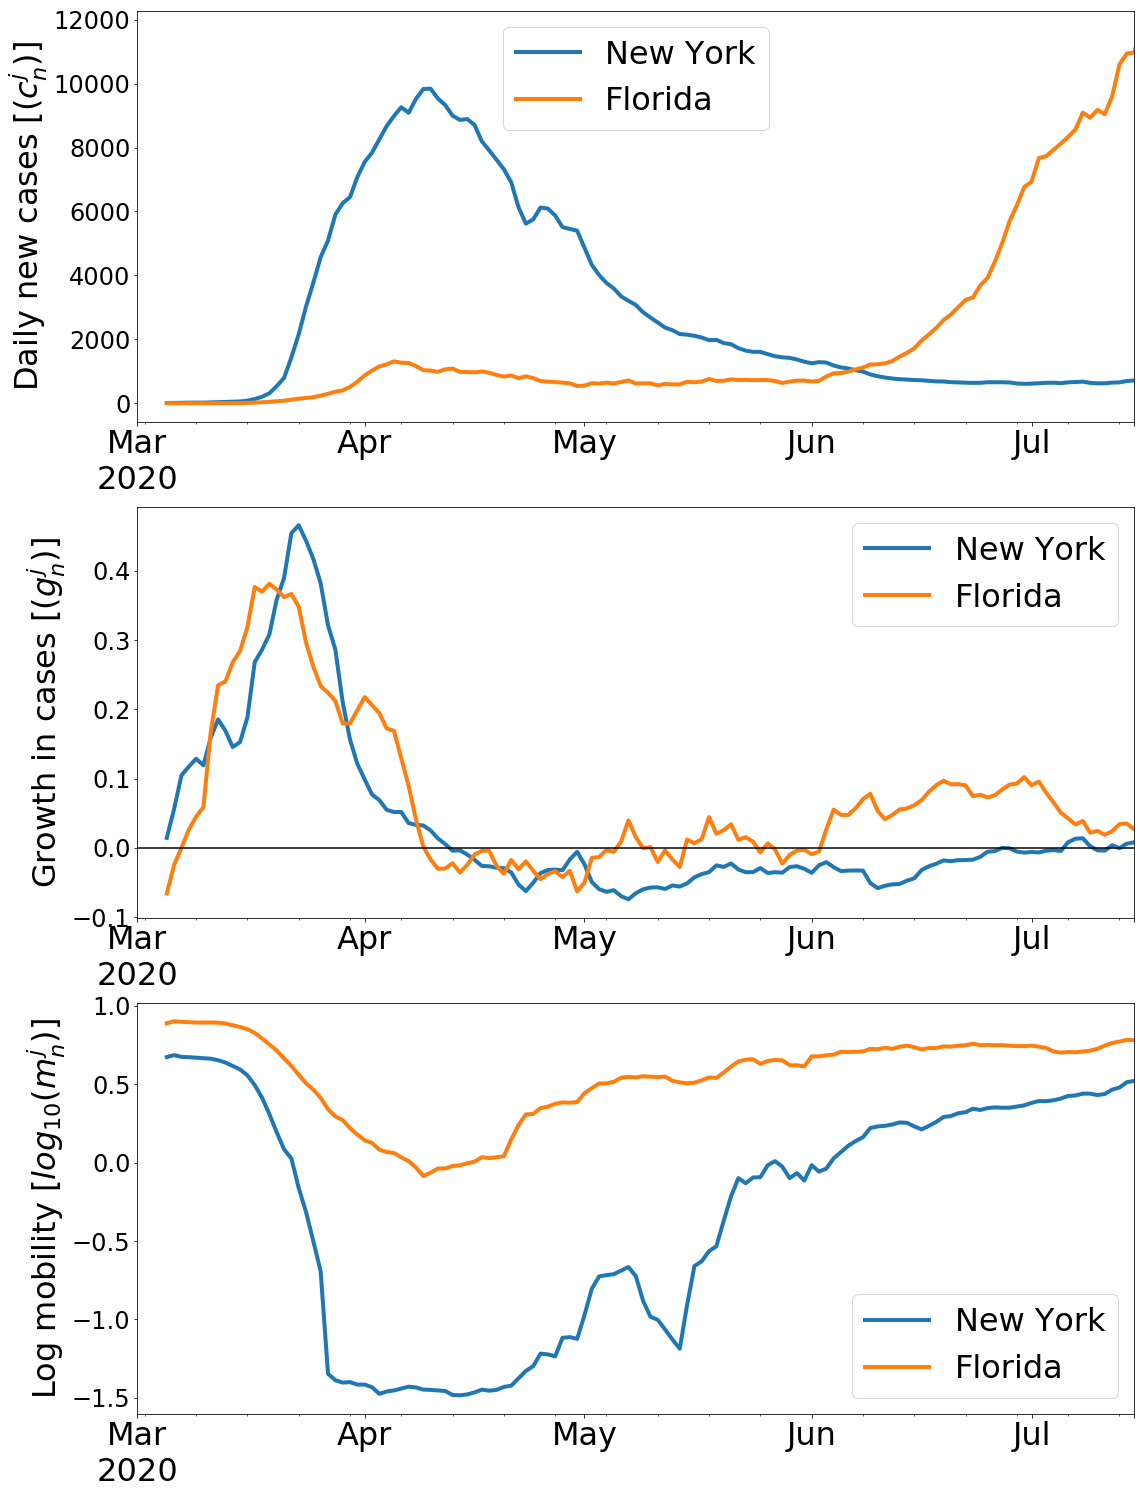

In [12]:
df_states_chosen = df_region[df_region['State'].isin(['Florida', 'New York'])]

plt.figure(figsize=(16,20))
ax = plt.subplot(3,1,1)
df_plot = numpy.exp(df_LogCases).copy()
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=32)
plt.ylabel('Daily new cases [$(c^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))
plt.tight_layout()

ax = plt.subplot(3,1,2)
df_plot = df_GrowthCases.copy()
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.axhline(c='k')
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=32)
plt.ylabel('Growth in cases [$(g^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))

ax = plt.subplot(3,1,3)
df_plot = df_LogMobility.copy()
df_plot.index = df_plot.index.to_period(freq='D')
df_plot = df_plot[df_states_chosen['pairs_id']]
df_plot.plot(ax=ax, lw=4)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.legend(df_states_chosen['State'], fontsize=32)
plt.xlabel('', size=12)
plt.ylabel('Log mobility [$log_{10}(m^j_n)$]', size=32)
plt.xlim(xmin=datetime(2020,3,1, tzinfo=pytz.utc))
plt.xlim(xmax=datetime(2020,7,15, tzinfo=pytz.utc))

#plt.tight_layout()
plt.show()

In [13]:
# df1: LogMobility
df1 = df_LogMobility.bfill().ffill()
# Create the multiindex
df1.columns = pandas.MultiIndex.from_product([df1.columns, ['LogMobility']])
df1.columns.names = ['pairs_id', None]

# df2: GrowthCases
# Note: no .bfill().ffill() for GrowthCases. Instead fillna(0) before taking rolling mean
df2 = df_GrowthCases
# Create the multiindex
df2.columns = pandas.MultiIndex.from_product([df2.columns, ['GrowthCases']])
df2.columns.names = ['pairs_id', None]

df_joined = df1.join(df2)
df_joined = df_joined.swaplevel(axis=1)

# Write to disk
df_joined.to_csv(os.path.join(data_subdirectory, 'df_joined_STATE.csv'))

df_joined.tail()

LogMobility                                          \
pairs_id                          121       122       123       124       125   
timestamp                                                                       
2020-09-03 00:00:00+00:00    0.952377  0.554004  0.597633  0.874308  0.447667   
2020-09-04 00:00:00+00:00    0.963761  0.547458  0.596786  0.881760  0.442704   
2020-09-05 00:00:00+00:00    0.964906  0.545484  0.592763  0.882752  0.425627   
2020-09-06 00:00:00+00:00    0.989843  0.574263  0.625690  0.909520  0.458058   
2020-09-07 00:00:00+00:00    1.000425  0.586317  0.644379  0.922144  0.473020   

                                                                             \
pairs_id                        126       127       128       129       130   
timestamp                                                                     
2020-09-03 00:00:00+00:00  0.683510  0.628856  0.698883  0.132900  0.749129   
2020-09-04 00:00:00+00:00  0.683639  0.623781  0.692797  0.146217  0.748099   
2020-09-05 00:00:00+00:00  0.682455  0.637676  0.704175  0.201163  0.745443   
2020-09-06 00:00:00+00:00  0.706120  0.660027  0.722949  0.226213  0.783975   
2020-09-07 00:00:00+00:00  0.718718  0.669986  0.735088  0.258302  0.798029   

                           ... GrowthCases                                \
pairs_id                   ...         162       163       164       165   
timestamp                  ...                                             
2020-09-03 00:00:00+00:00  ...    0.058458  0.011770 -0.020394  0.009300   
2020-09-04 00:00:00+00:00  ...    0.043442  0.003146 -0.012730  0.018291   
2020-09-05 00:00:00+00:00  ...    0.025104  0.003529 -0.037076  0.012736   
2020-09-06 00:00:00+00:00  ...   -0.006283  0.035071 -0.029797  0.001686   
2020-09-07 00:00:00+00:00  ...   -0.010487  0.002059 -0.051039  0.009283   

                                                                             \
pairs_id                        166       167       168       169       170   
timestamp                                                                     
2020-09-03 00:00:00+00:00  0.014062  0.009332 -0.005105  0.094926 -0.009126   
2020-09-04 00:00:00+00:00 -0.040372  0.010476 -0.018357  0.078712  0.002192   
2020-09-05 00:00:00+00:00 -0.069980  0.005203 -0.014237  0.084181  0.008162   
2020-09-06 00:00:00+00:00 -0.111929  0.009266 -0.017421  0.072685  0.015070   
2020-09-07 00:00:00+00:00 -0.129542 -0.001435 -0.015079  0.050453  0.038429   

                                     
pairs_id                        171  
timestamp                            
2020-09-03 00:00:00+00:00 -0.051409  
2020-09-04 00:00:00+00:00 -0.059582  
2020-09-05 00:00:00+00:00 -0.042050  
2020-09-06 00:00:00+00:00 -0.012051  
2020-09-07 00:00:00+00:00 -0.002017  

[5 rows x 102 columns]

/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


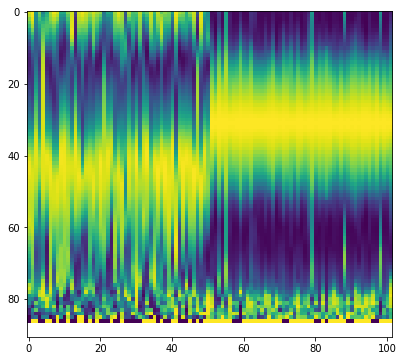

14 0.8498937456441518


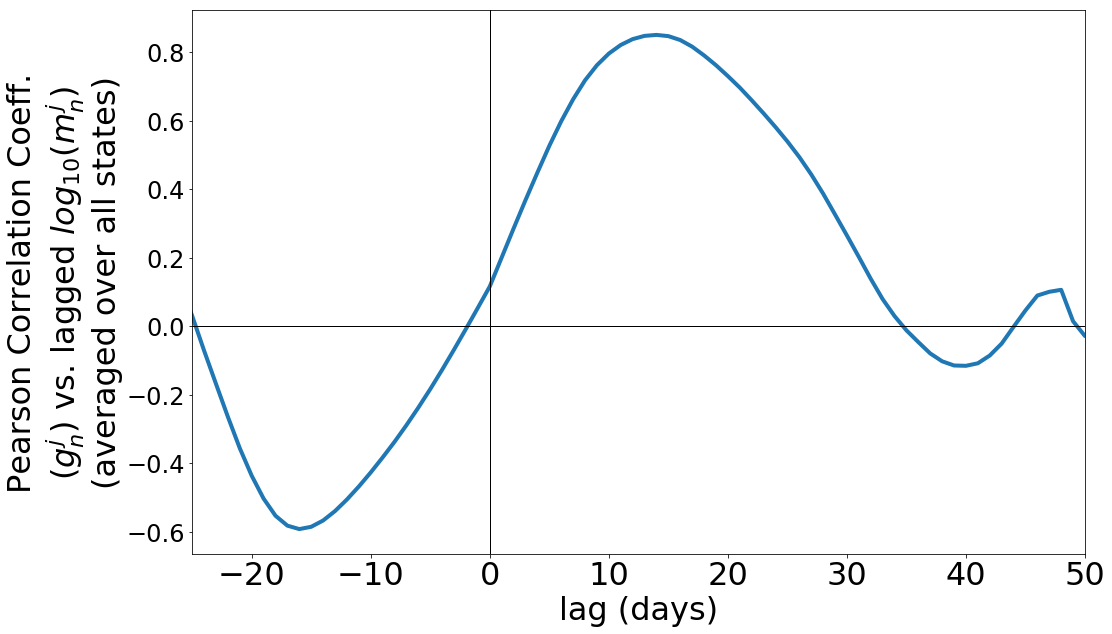

In [14]:
# Correlation with LogMobility
lag_days = numpy.arange(91) - 31
dt_cutoff_start = datetime(2020, 1, 1, tzinfo=pytz.utc)
dt_cutoff_end = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_lagged_correlation = pandas.DataFrame()
for pairs_id in df_region['pairs_id'].values:
    df = df_joined[['LogMobility', 'GrowthCases']].swaplevel(axis=1)[pairs_id]
    df = df[df.index>=dt_cutoff_start]
    df = df[df.index<=dt_cutoff_end]

    lagged_correlation = pandas.DataFrame.from_dict(
        {x: [df['LogMobility'].corr(df[x].shift(-t)) for t in lag_days] for x in df.columns})
    lagged_correlation['pairs_id'] = pairs_id
    lagged_correlation['lag_days'] = lag_days
    df_lagged_correlation = pandas.concat([df_lagged_correlation, lagged_correlation])
    
df_lagged_correlation = df_lagged_correlation.set_index(['lag_days', 'pairs_id']).unstack()

plt.figure(figsize=(20,6))
plt.imshow(df_lagged_correlation)
plt.show()

df_lagged_correlation.head()

from matplotlib.offsetbox import AnchoredText
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.plot(df_lagged_correlation['GrowthCases'].mean(axis=1), lw=4)
plt.xlabel('lag (days)', size=32)
plt.ylabel('Pearson Correlation Coeff.\n$(g^j_n)$ vs. lagged $log_{10}(m^j_n)$\n(averaged over all states)', size=32)
plt.axvline(color='k', lw=1)
plt.axhline(color='k', lw=1)
plt.xticks(fontsize=32)
plt.yticks(fontsize=24)
plt.xlim(xmin=-25, xmax=50)

cases_lag_measured = df_lagged_correlation['GrowthCases'].mean(axis=1).idxmax()
print(cases_lag_measured, df_lagged_correlation.loc[cases_lag_measured, 'GrowthCases'].mean())

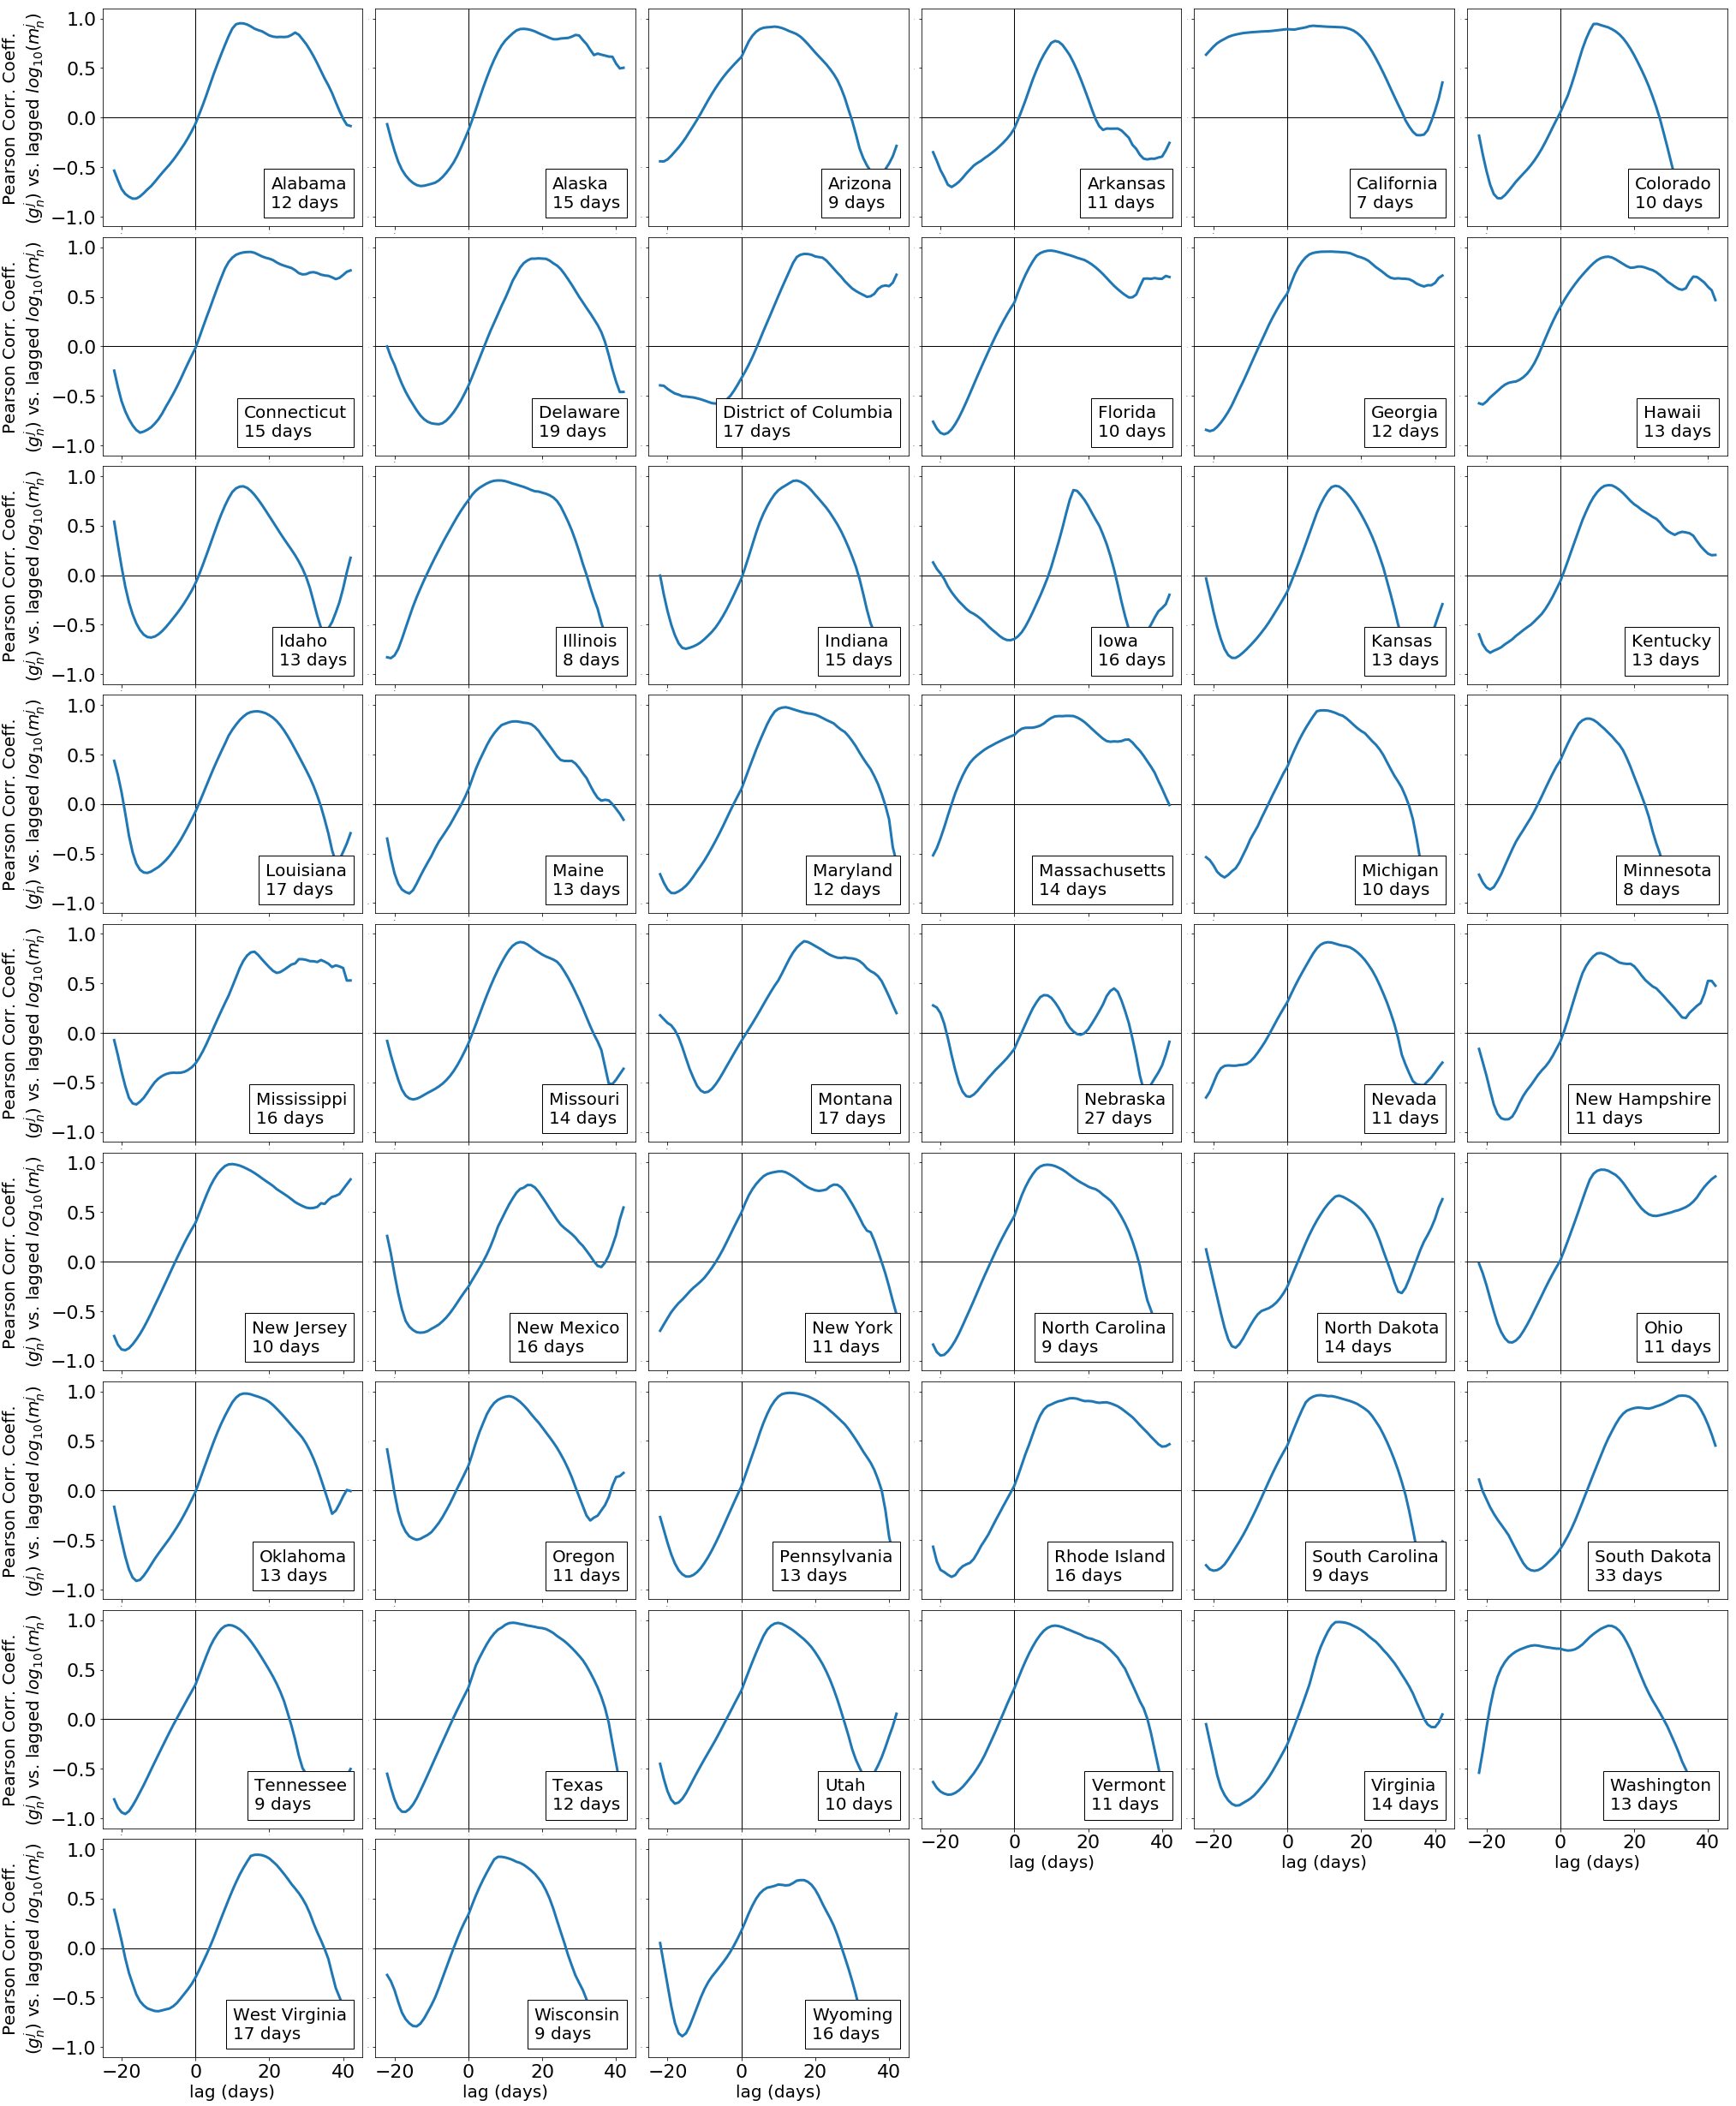

In [15]:
# Individual State Correlations
df_state_correlations = pandas.DataFrame()

fig = plt.figure(figsize=(34, 44)) # letter size 8.5 * 11
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, pairs_id in enumerate(df_region.sort_values(by='State')['pairs_id'].values):

    df_single = df_lagged_correlation['GrowthCases'][pairs_id]
    df_single = df_single.loc[-22:42]

    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]
    row['argmax'] = df_single.idxmax()
    row['R'] = numpy.round(df_single.max(), 2)
    
    if len(df_single)>0:
        ax = plt.subplot(9, 6,i+1)
        plt.axhline(color='k', lw=1)
        plt.axvline(color='k', lw=1)
        
        plt.plot(df_single, lw=3)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        ax.locator_params(tight=True, nbins=5)
            
        #plt.xlim(xmin=-2.5, xmax=1.5)
        plt.ylim(ymin=-1.1, ymax=1.1)

        anchored_text = AnchoredText(title_string + '\n' + str(row['argmax']) + ' days', loc=4, prop=dict(size=20))
        ax.add_artist(anchored_text)

        df_state_correlations = df_state_correlations.append(pandas.DataFrame(row, index=[0]))

        if (i>44):
            plt.xlabel('lag (days)', size=20)
            plt.xticks(fontsize=22)
        else:
            plt.xticks(fontsize=0)
            
        if (i%6==0):
            plt.ylabel('Pearson Corr. Coeff.\n$(g^j_n)$ vs. lagged $log_{10}(m^j_n)$', size=20)
            plt.yticks(fontsize=22)
        else:
            plt.yticks(fontsize=0)

#plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'state_correlations_RW14.svg'))
plt.show()

In [16]:
df_state_correlations[['argmax', 'R']].describe()

argmax          R
count  51.000000  51.000000
mean   13.235294   0.903333
std     4.465818   0.095345
min     7.000000   0.450000
25%    10.500000   0.895000
50%    13.000000   0.930000
75%    15.000000   0.955000
max    33.000000   0.980000

In [17]:
lag_cases = cases_lag_measured
print('cases_lag_measured', cases_lag_measured)
# Shifting only the growth
df_lagged_growth_cases = df_joined[['GrowthCases']].shift(periods=-lag_cases)
df_lagged = pandas.merge(df_joined[['LogMobility']],
                          df_joined[['GrowthCases']].shift(periods=-lag_cases),
                          left_index=True,
                          right_index=True)

df_lagged = df_lagged.swaplevel(axis=1)
df_lagged.tail()

cases_lag_measured 14


pairs_id                          121         122         123         124  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.952377    0.554004    0.597633    0.874308   
2020-09-04 00:00:00+00:00    0.963761    0.547458    0.596786    0.881760   
2020-09-05 00:00:00+00:00    0.964906    0.545484    0.592763    0.882752   
2020-09-06 00:00:00+00:00    0.989843    0.574263    0.625690    0.909520   
2020-09-07 00:00:00+00:00    1.000425    0.586317    0.644379    0.922144   

pairs_id                          125         126         127         128  \
                          LogMobility LogMobility LogMobility LogMobility   
timestamp                                                                   
2020-09-03 00:00:00+00:00    0.447667    0.683510    0.628856    0.698883   
2020-09-04 00:00:00+00:00    0.442704    0.683639    0.623781    0.692797   
2020-09-05 00:00:00+00:00    0.425627    0.682455    0.637676    0.704175   
2020-09-06 00:00:00+00:00    0.458058    0.706120    0.660027    0.722949   
2020-09-07 00:00:00+00:00    0.473020    0.718718    0.669986    0.735088   

pairs_id                          129         130  ...         162  \
                          LogMobility LogMobility  ... GrowthCases   
timestamp                                          ...               
2020-09-03 00:00:00+00:00    0.132900    0.749129  ...         NaN   
2020-09-04 00:00:00+00:00    0.146217    0.748099  ...         NaN   
2020-09-05 00:00:00+00:00    0.201163    0.745443  ...         NaN   
2020-09-06 00:00:00+00:00    0.226213    0.783975  ...         NaN   
2020-09-07 00:00:00+00:00    0.258302    0.798029  ...         NaN   

pairs_id                          163         164         165         166  \
                          GrowthCases GrowthCases GrowthCases GrowthCases   
timestamp                                                                   
2020-09-03 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-04 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-07 00:00:00+00:00         NaN         NaN         NaN         NaN   

pairs_id                          167         168         169         170  \
                          GrowthCases GrowthCases GrowthCases GrowthCases   
timestamp                                                                   
2020-09-03 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-04 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-05 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-06 00:00:00+00:00         NaN         NaN         NaN         NaN   
2020-09-07 00:00:00+00:00         NaN         NaN         NaN         NaN   

pairs_id                          171  
                          GrowthCases  
timestamp                              
2020-09-03 00:00:00+00:00         NaN  
2020-09-04 00:00:00+00:00         NaN  
2020-09-05 00:00:00+00:00         NaN  
2020-09-06 00:00:00+00:00         NaN  
2020-09-07 00:00:00+00:00         NaN  

[5 rows x 102 columns]

/home/ipython/software/python2/virtualenv/pypairs-latest/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


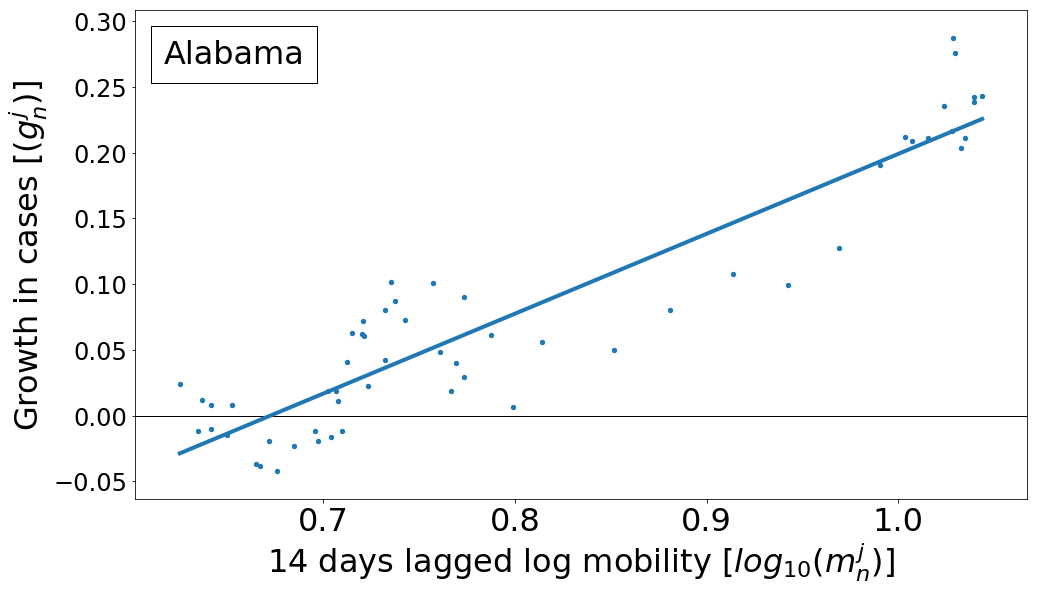

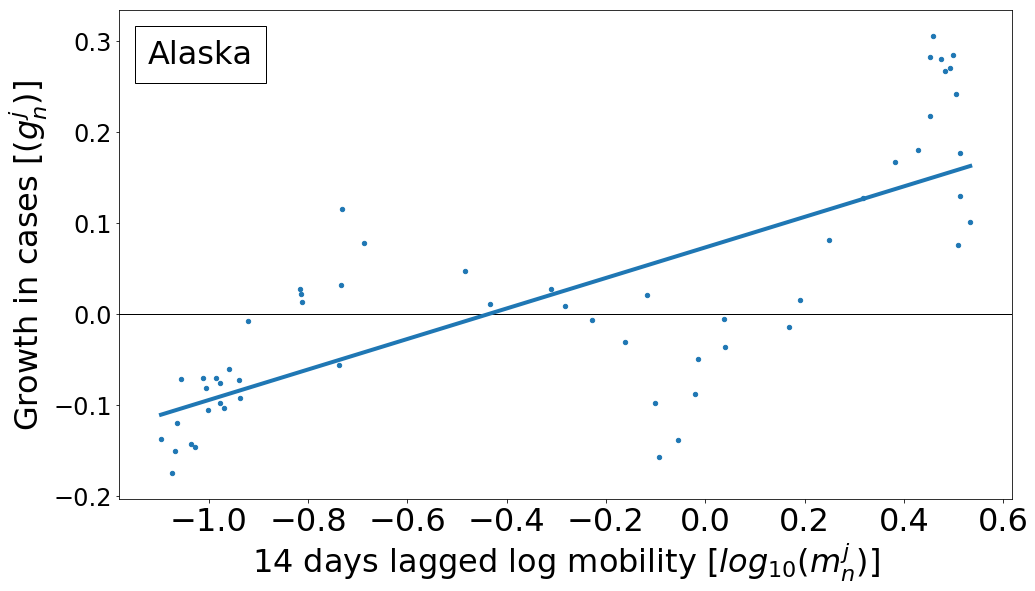

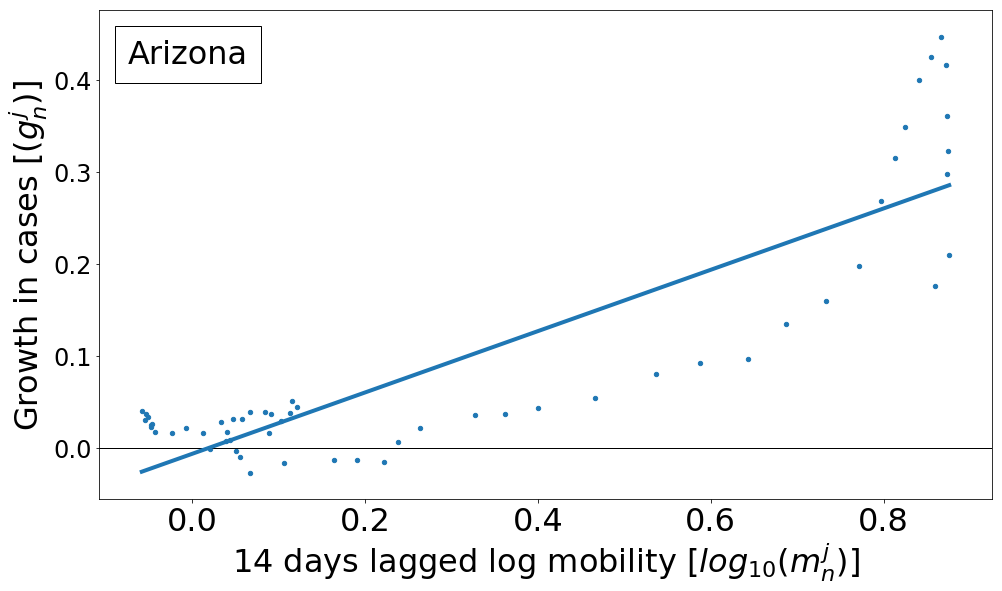

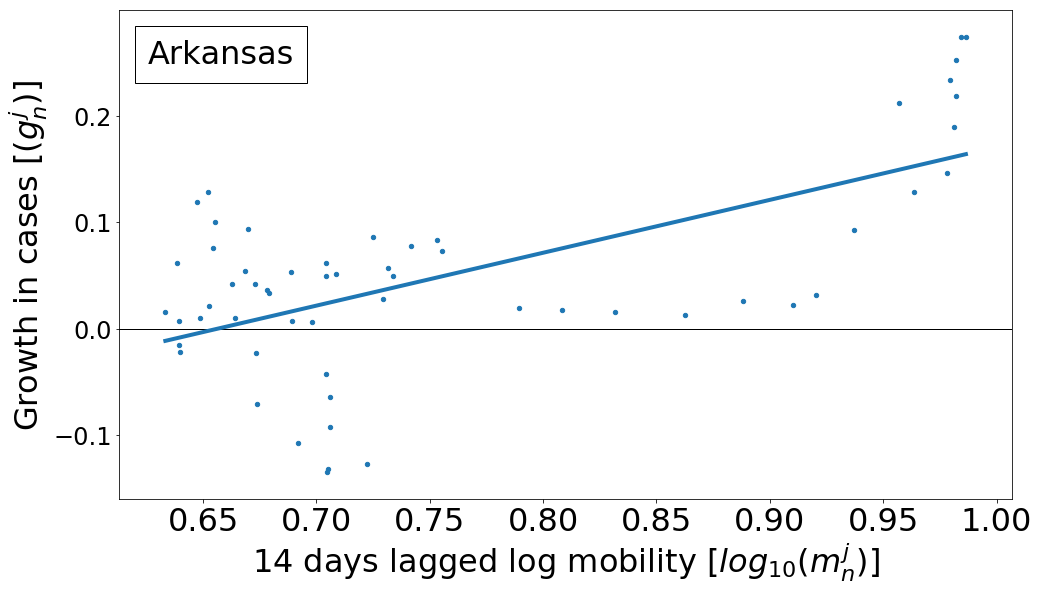

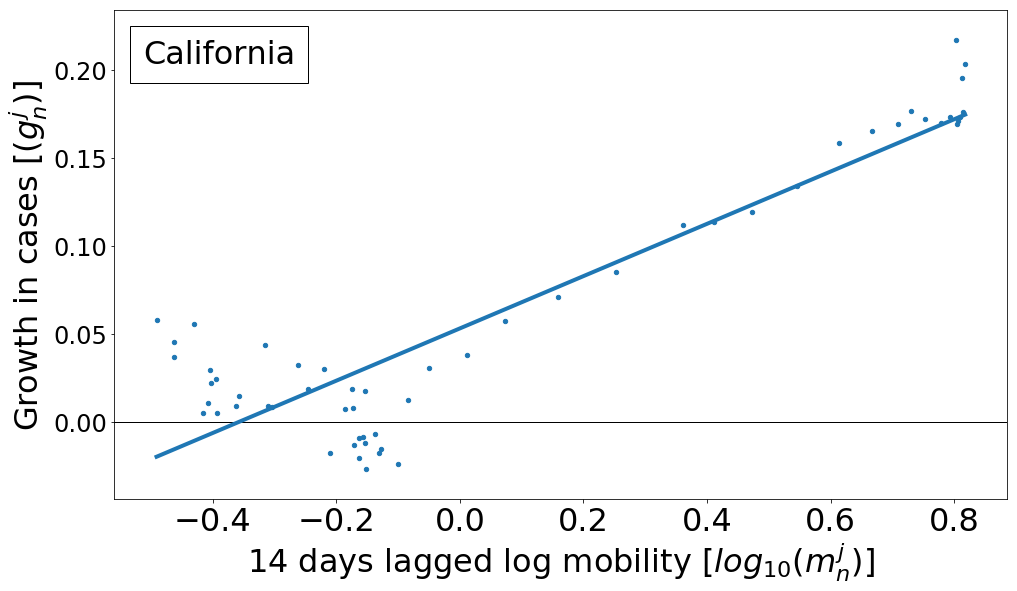

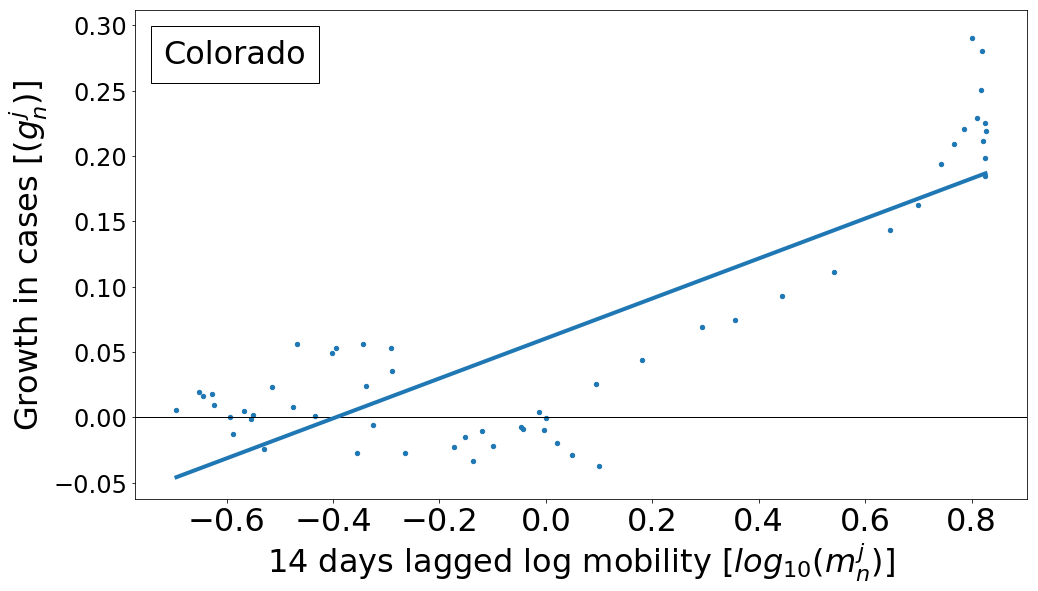

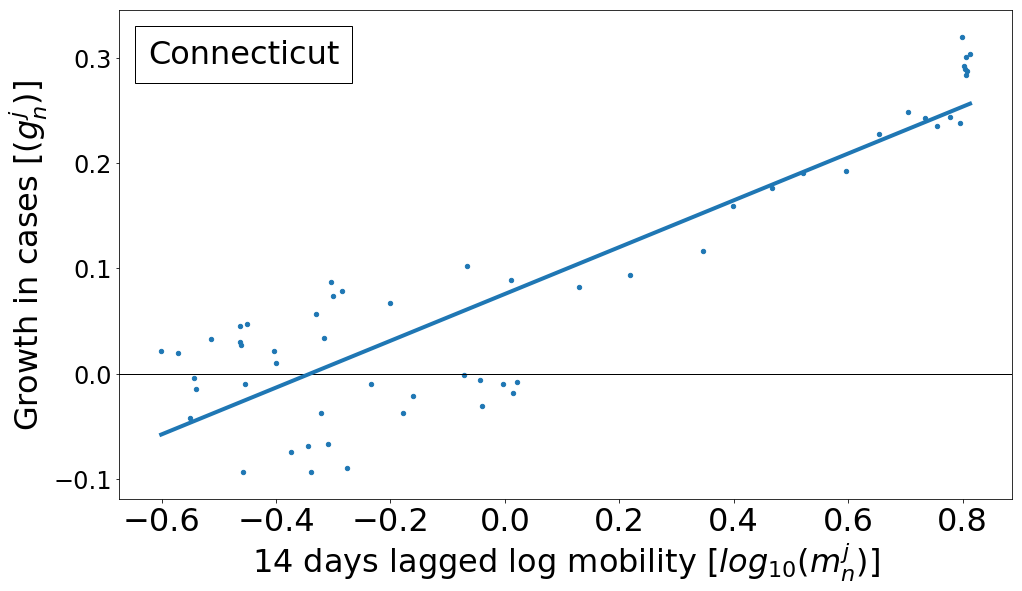

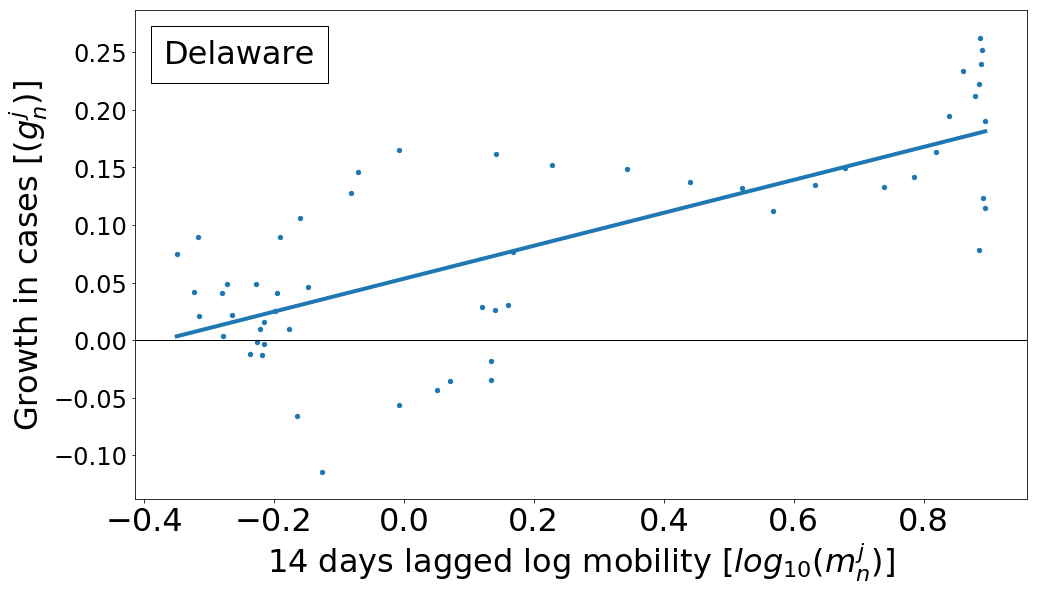

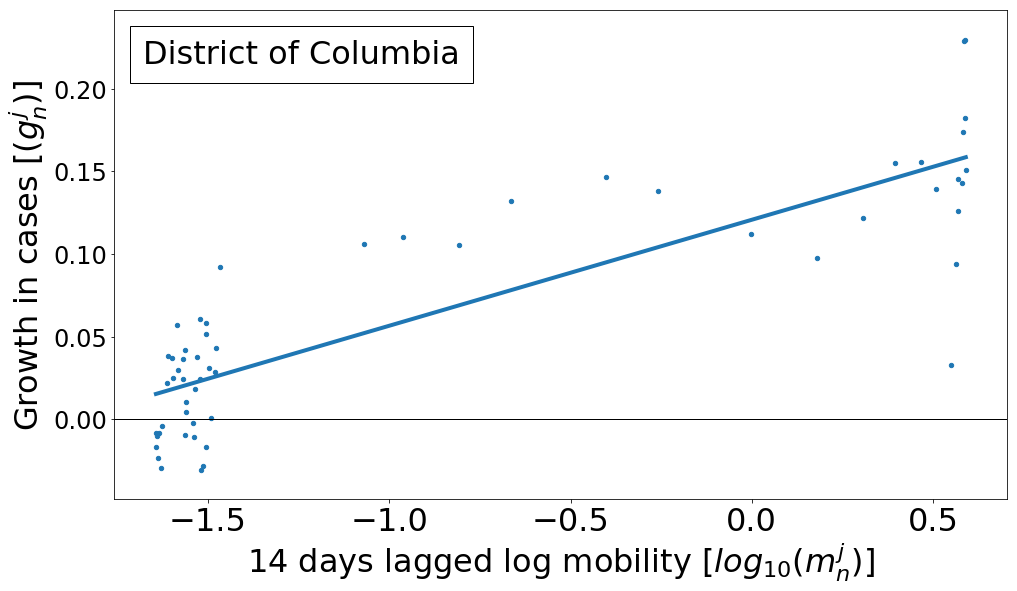

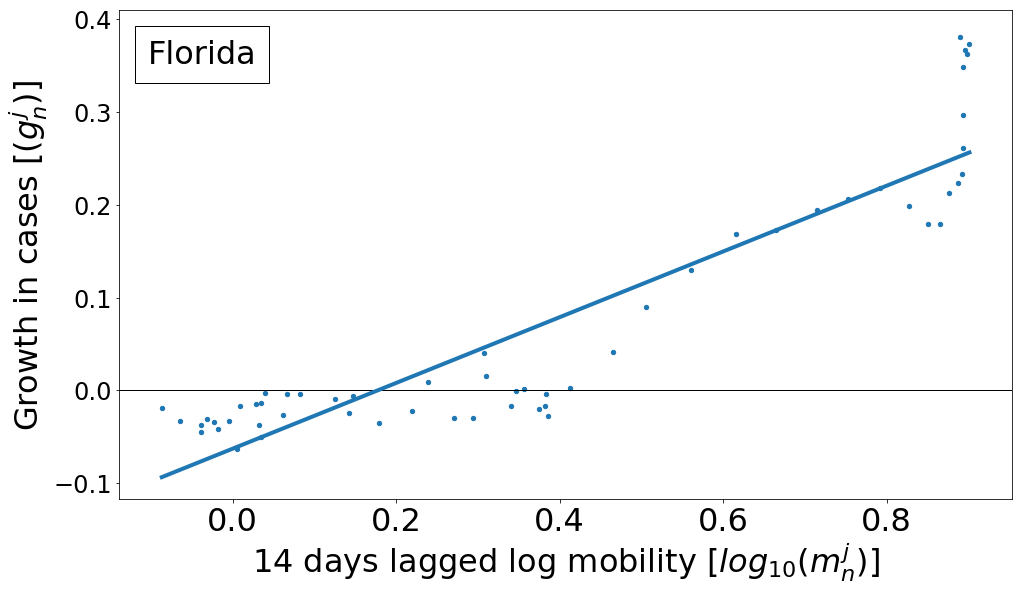

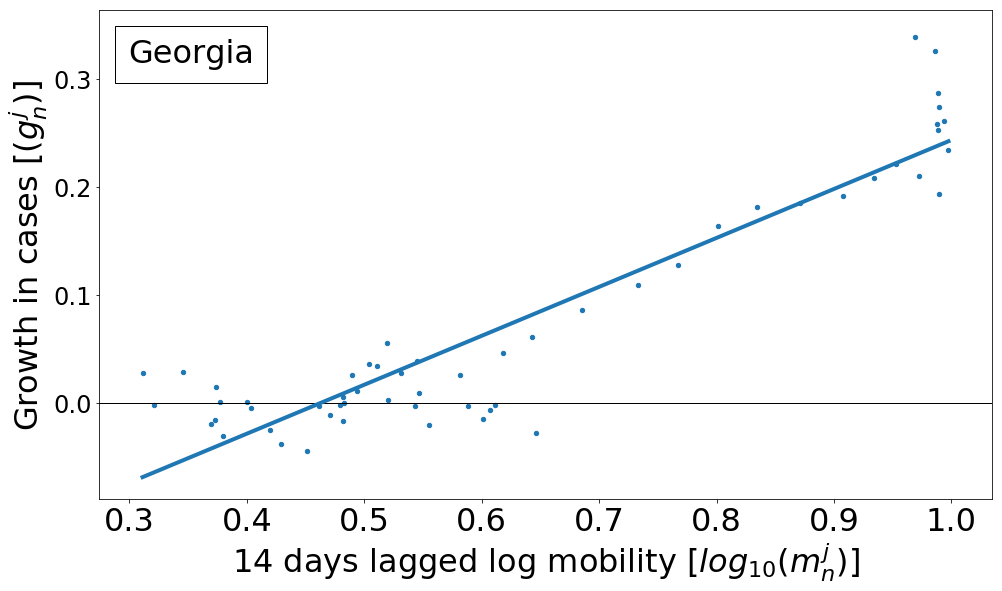

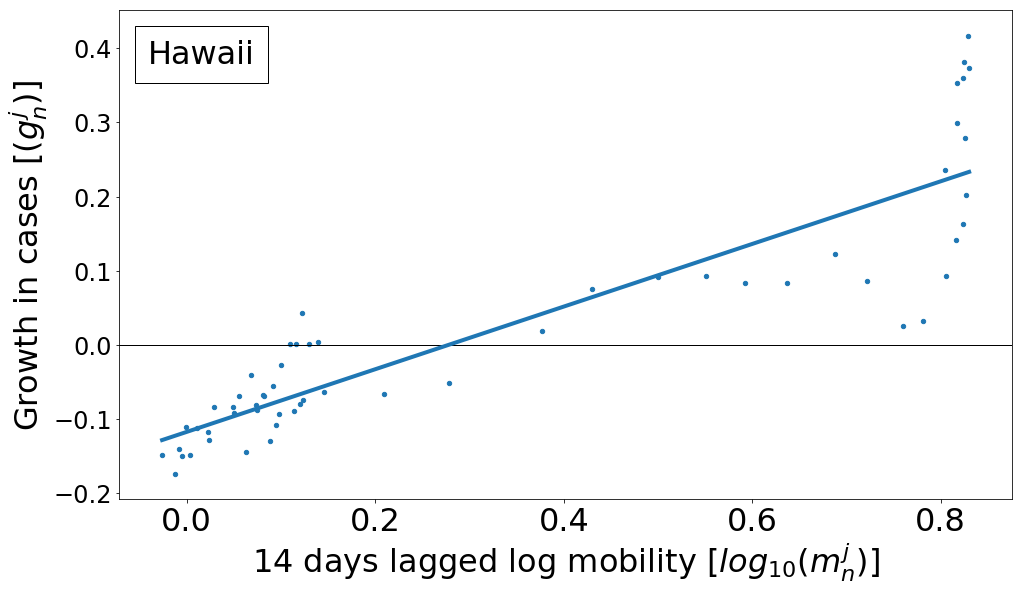

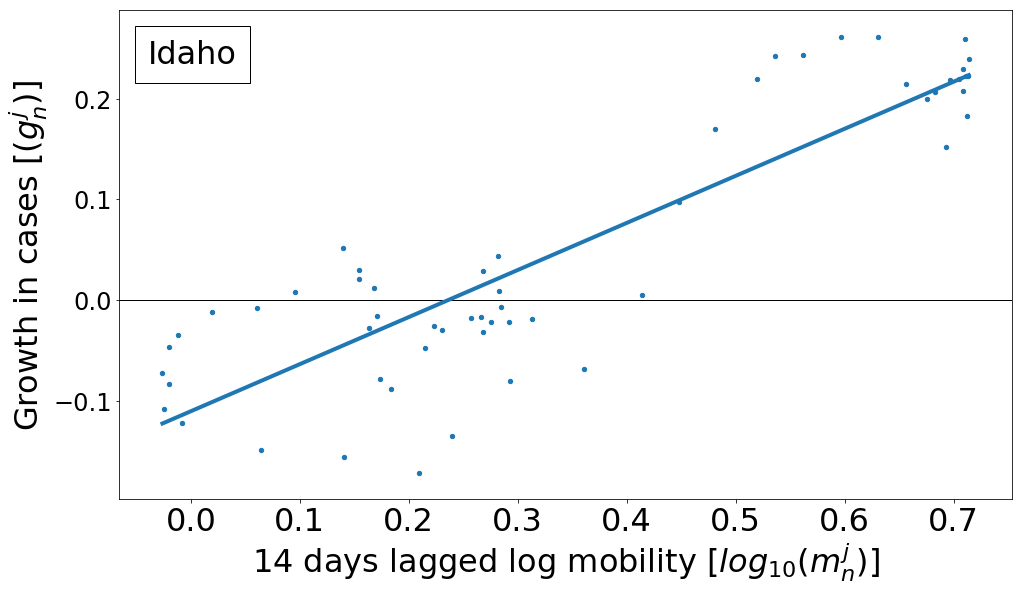

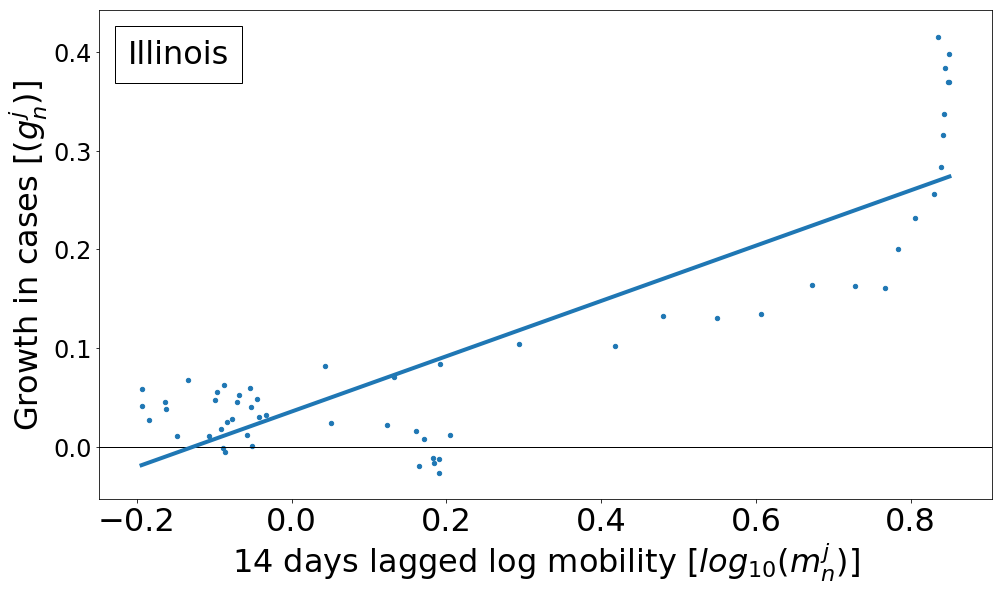

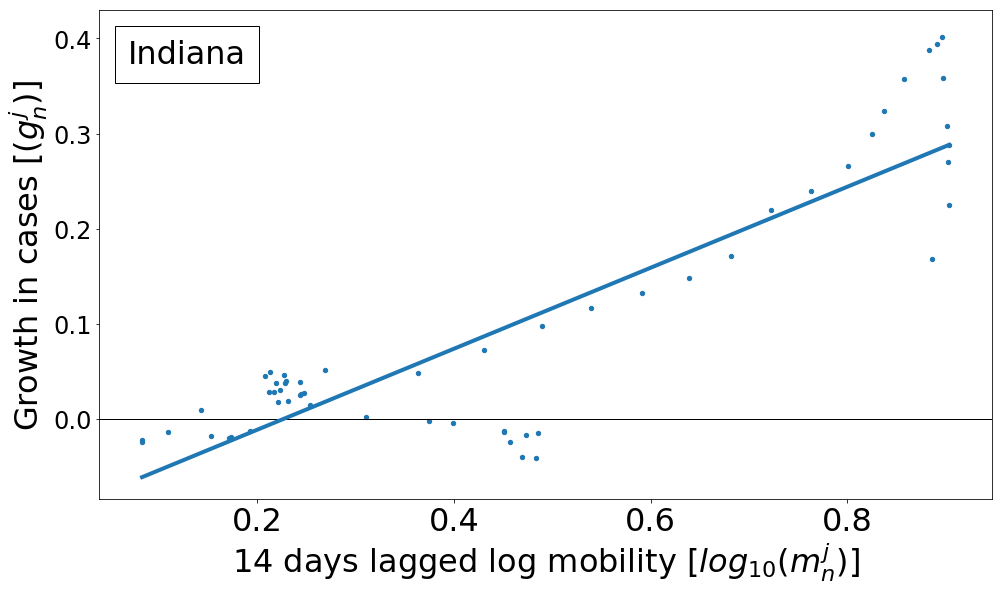

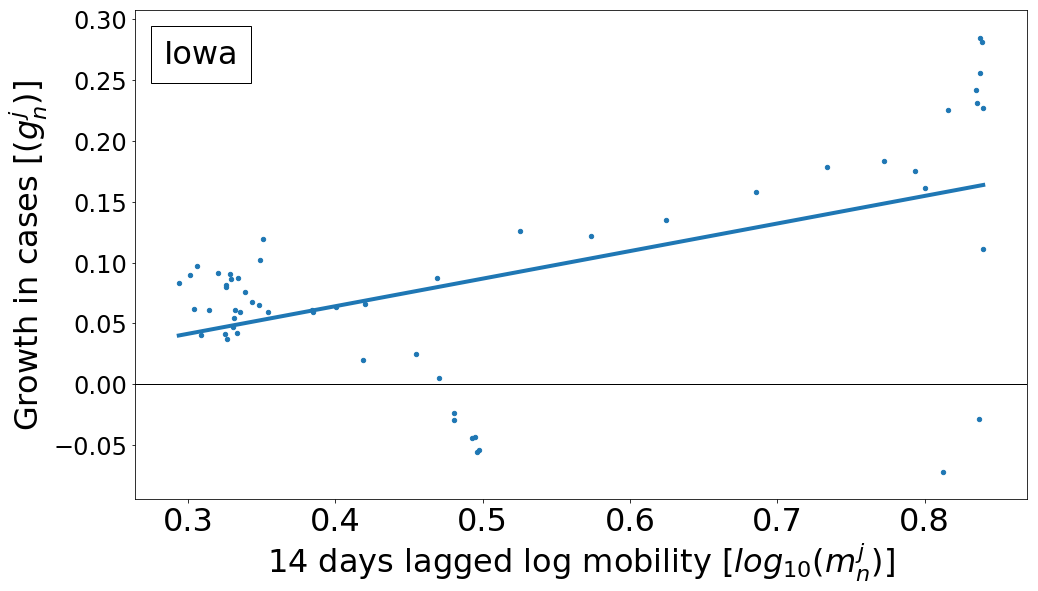

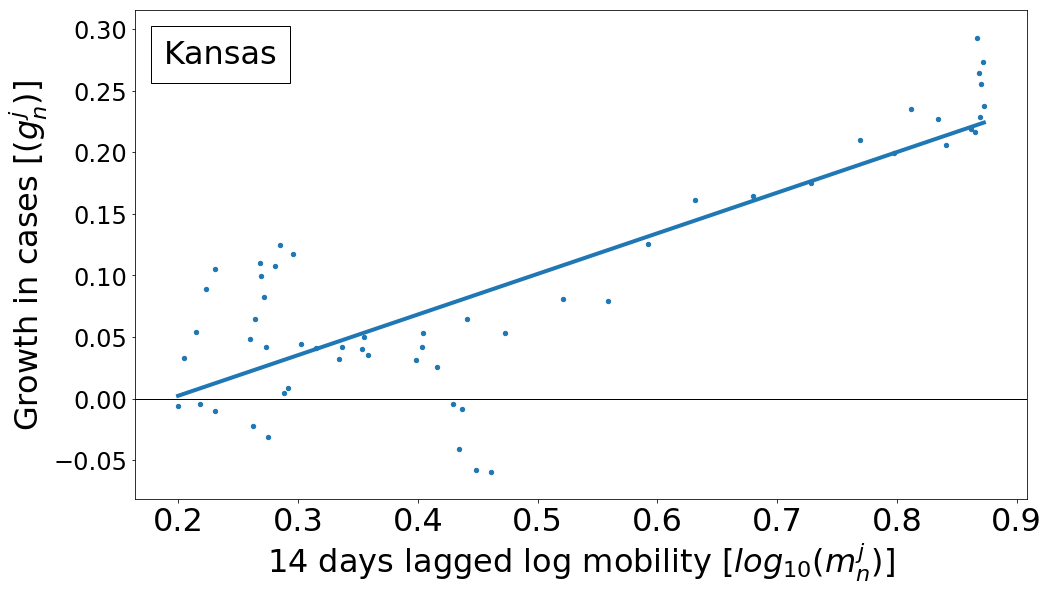

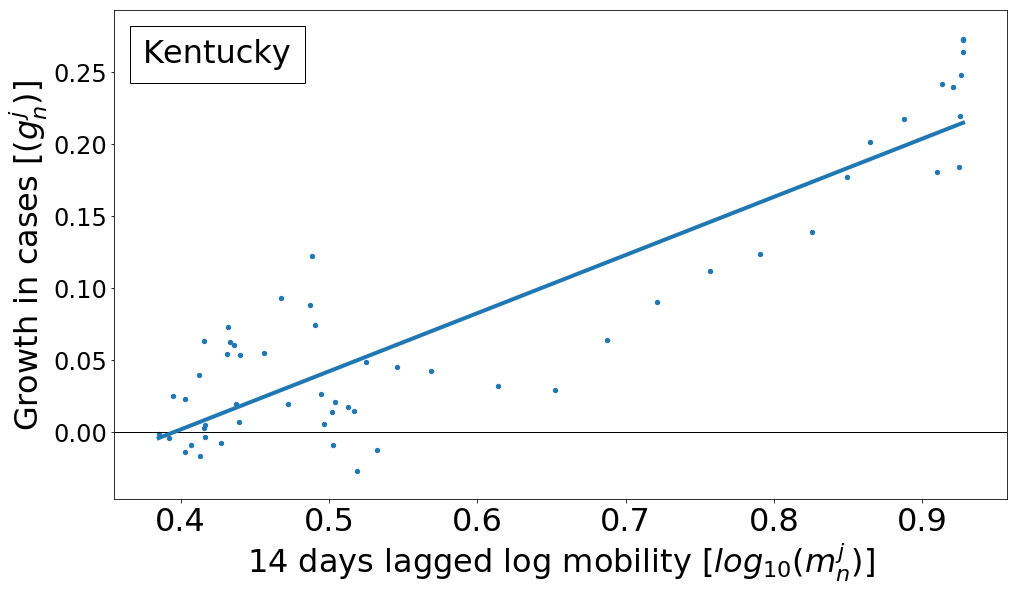

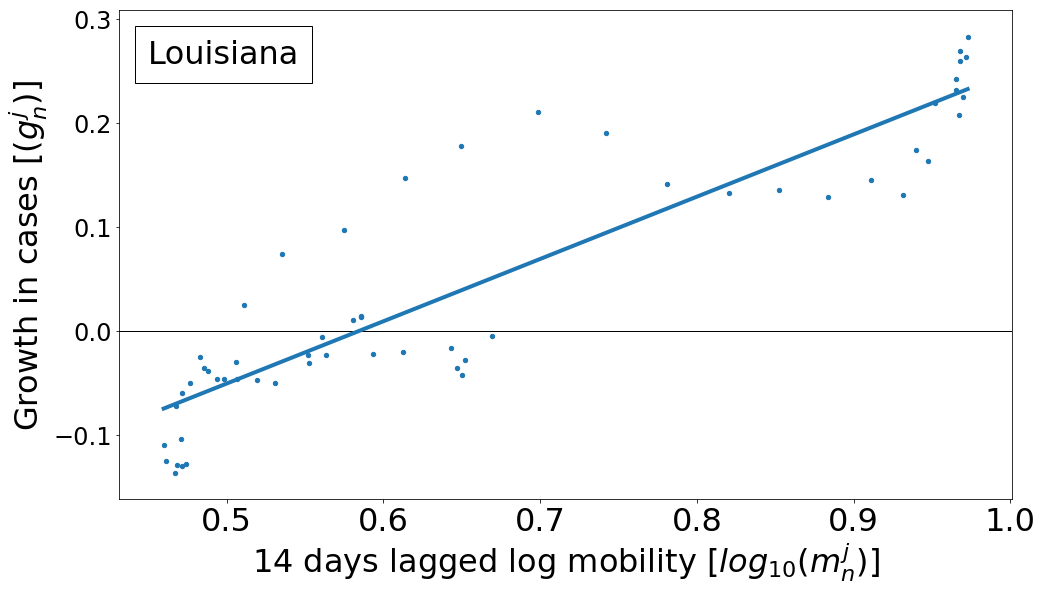

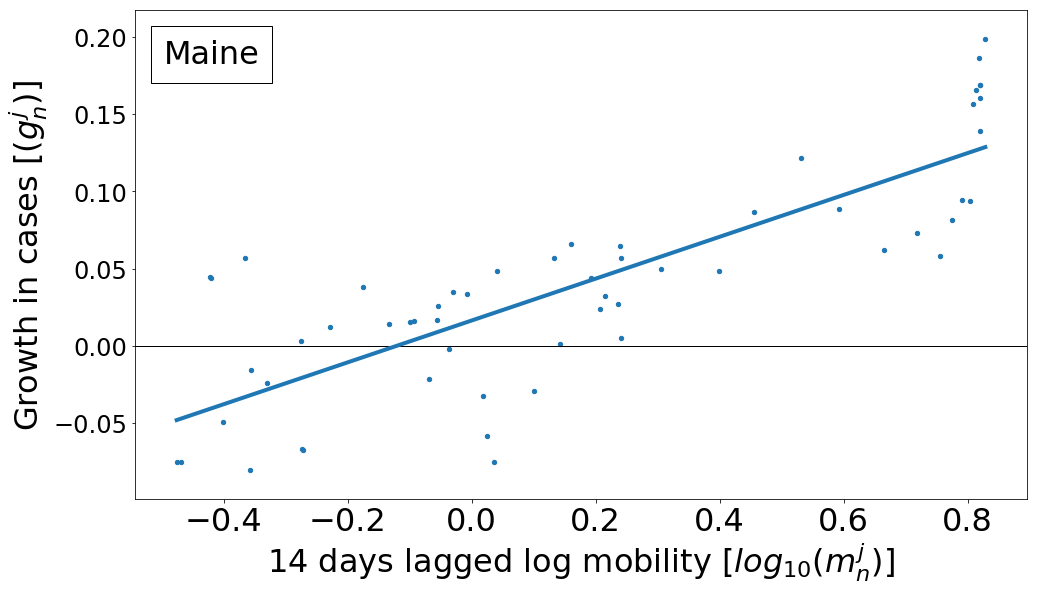

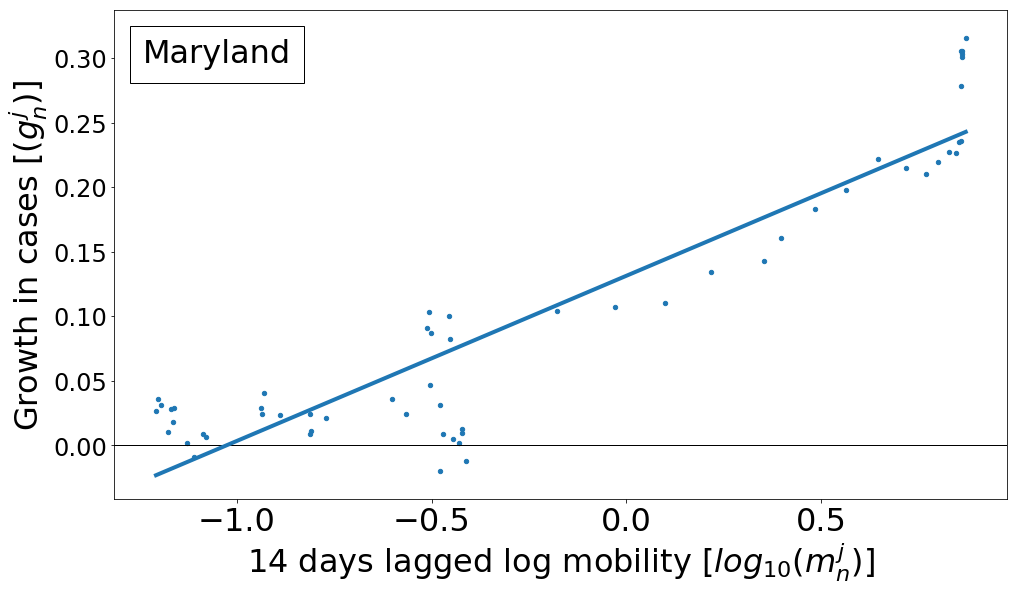

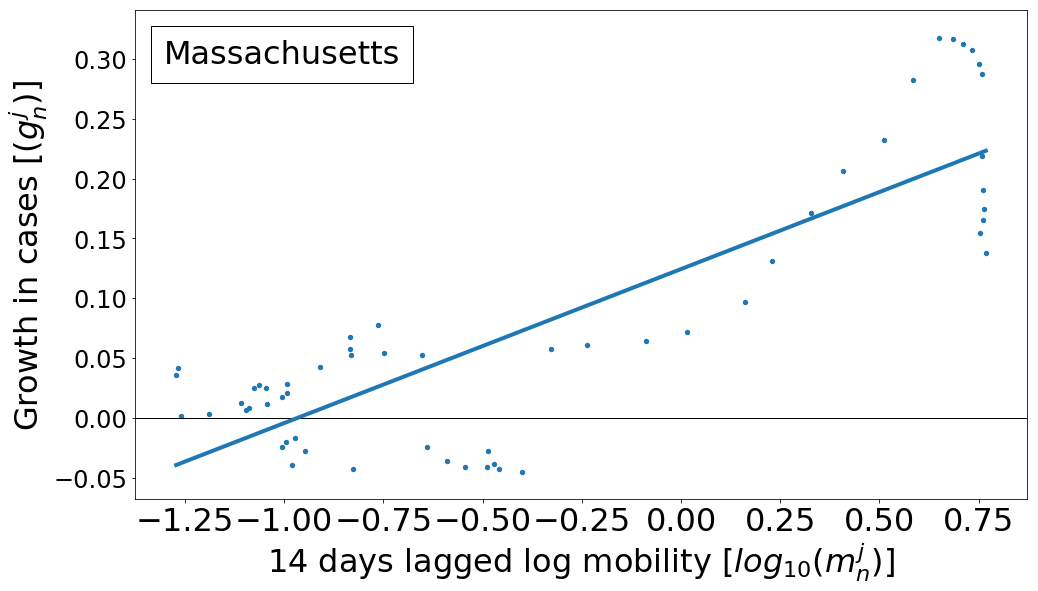

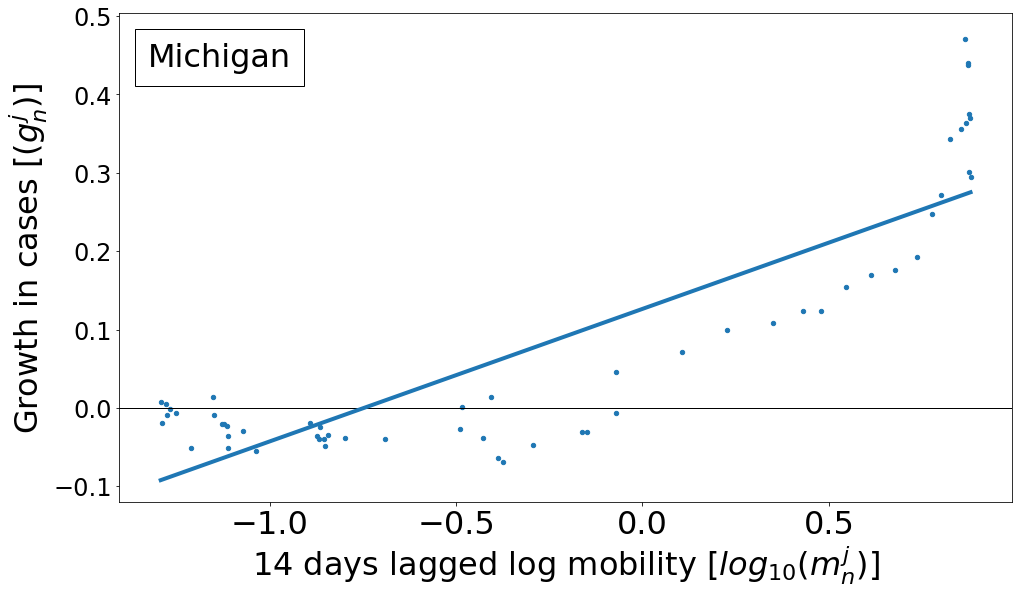

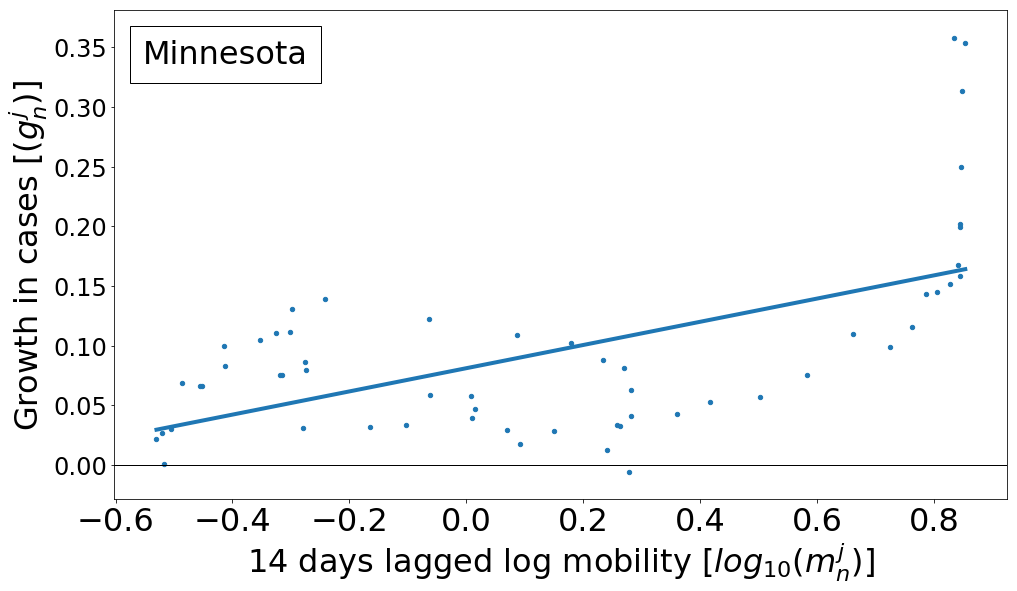

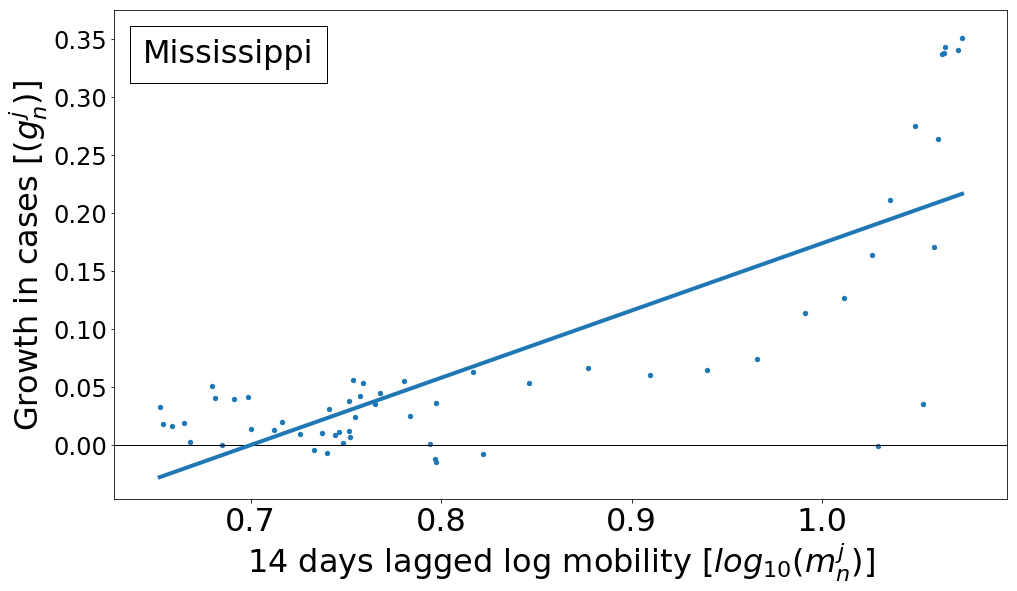

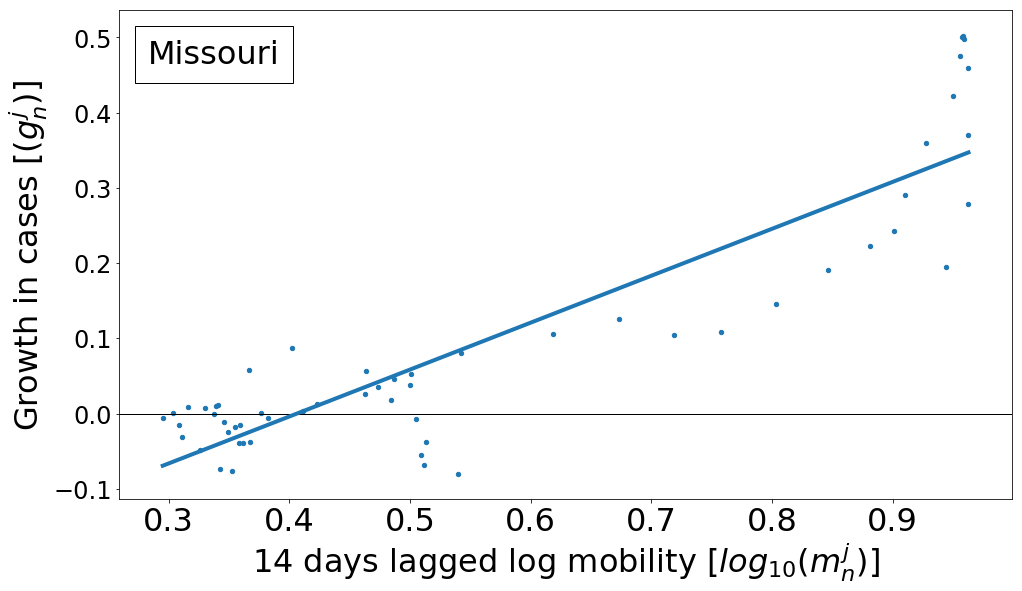

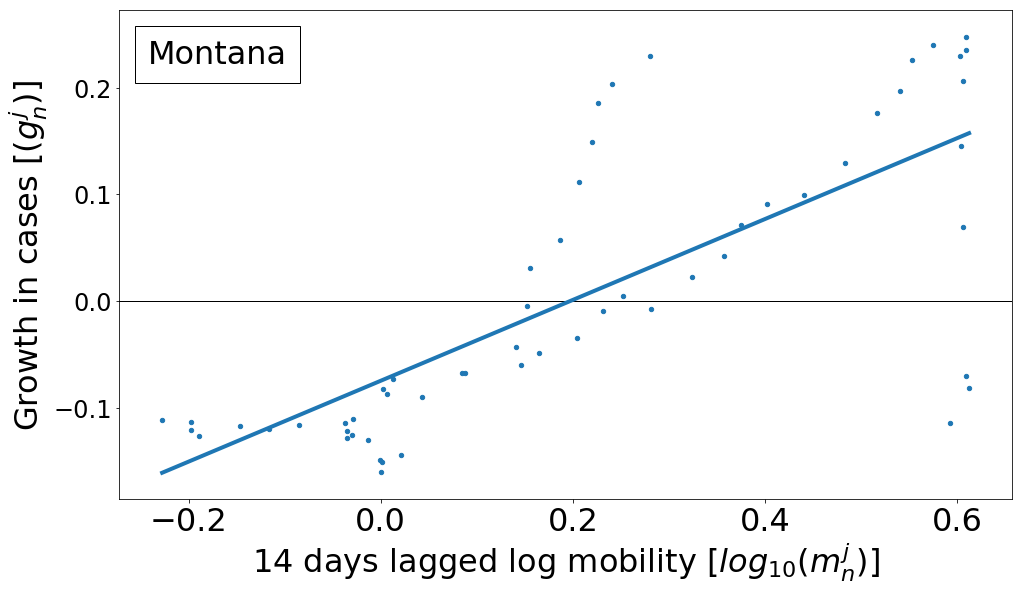

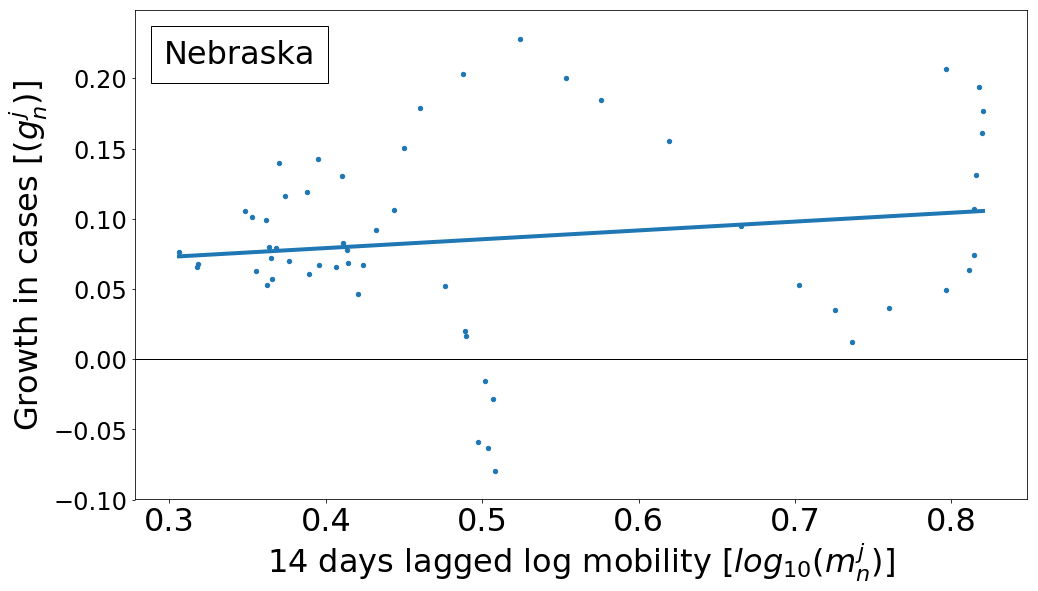

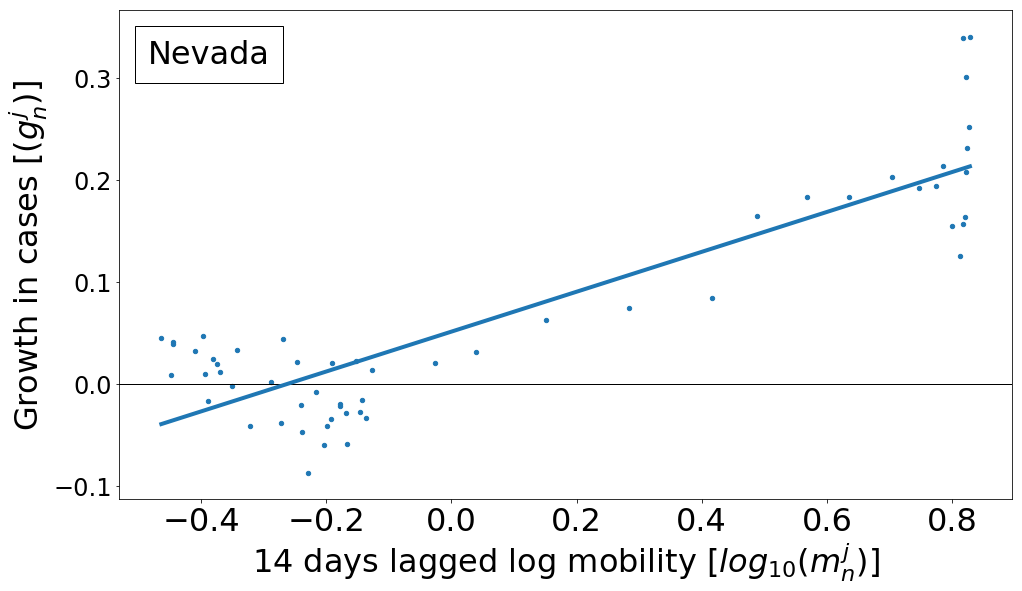

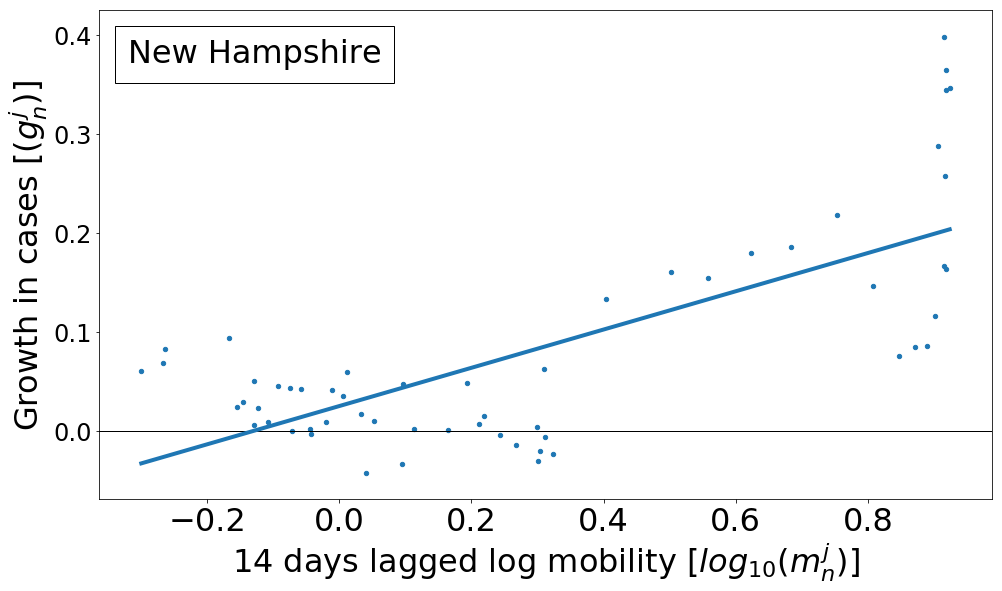

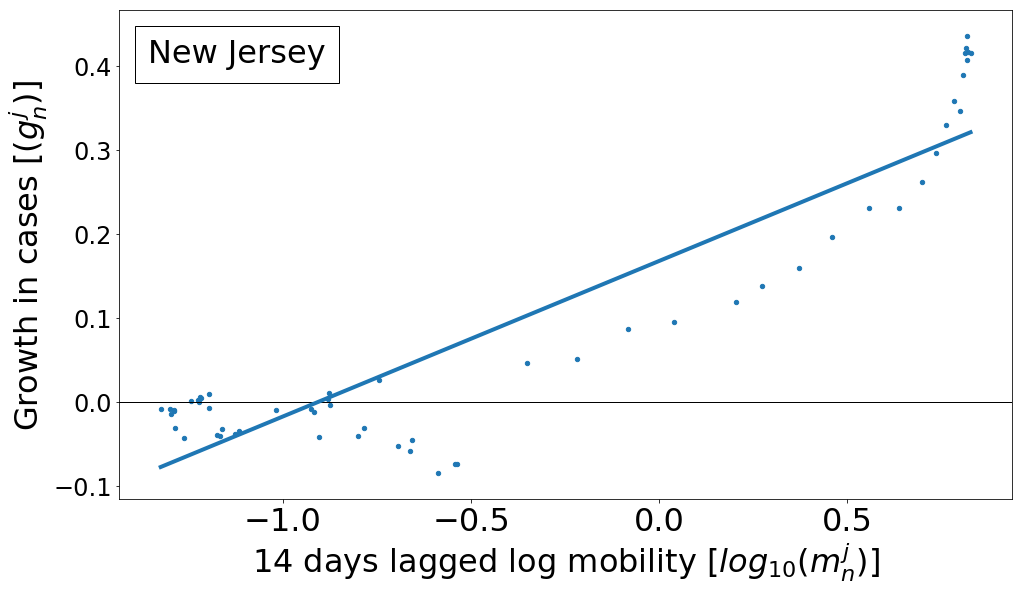

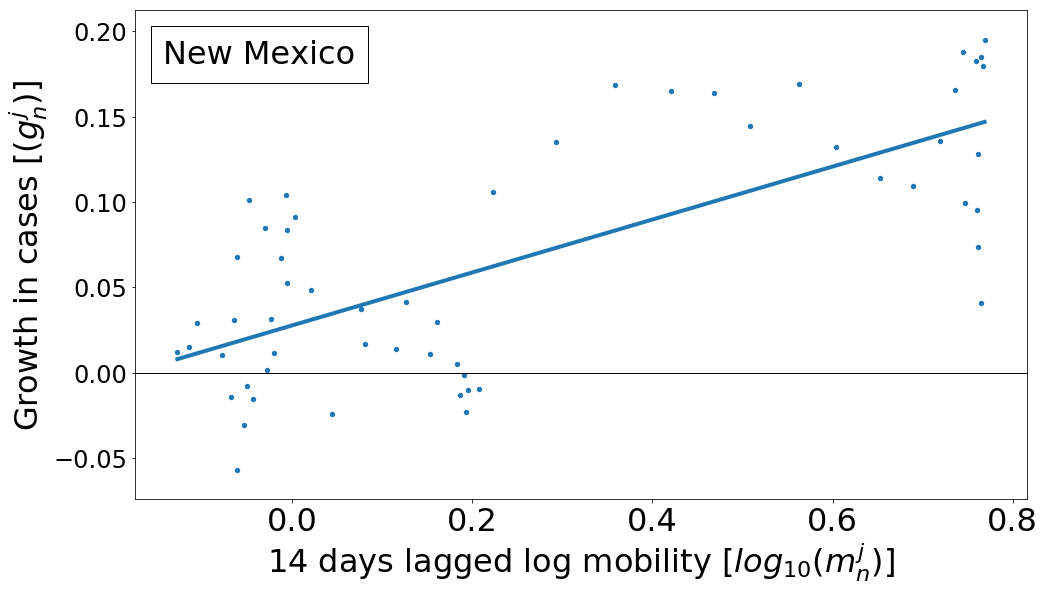

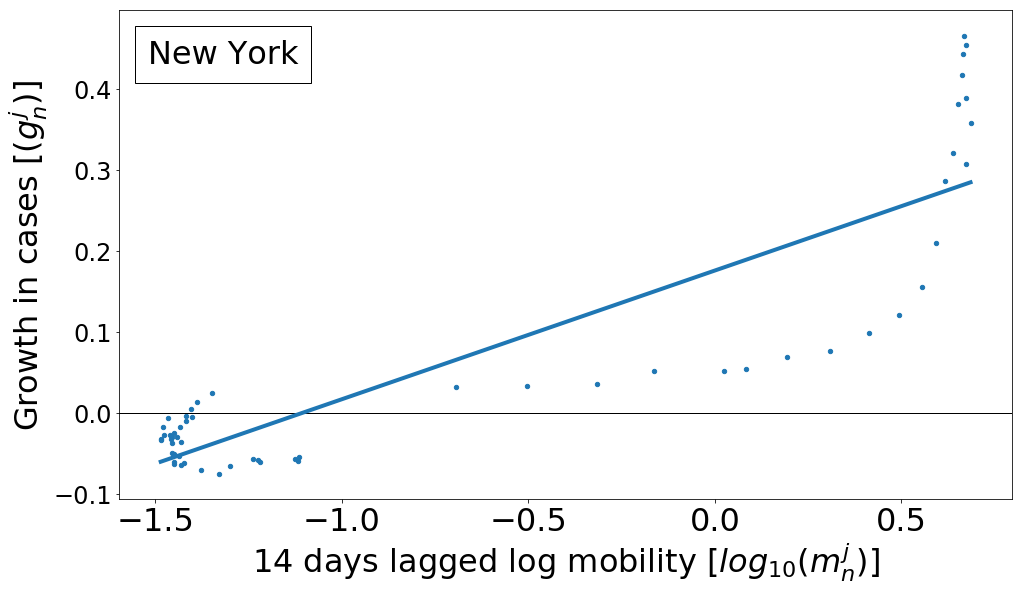

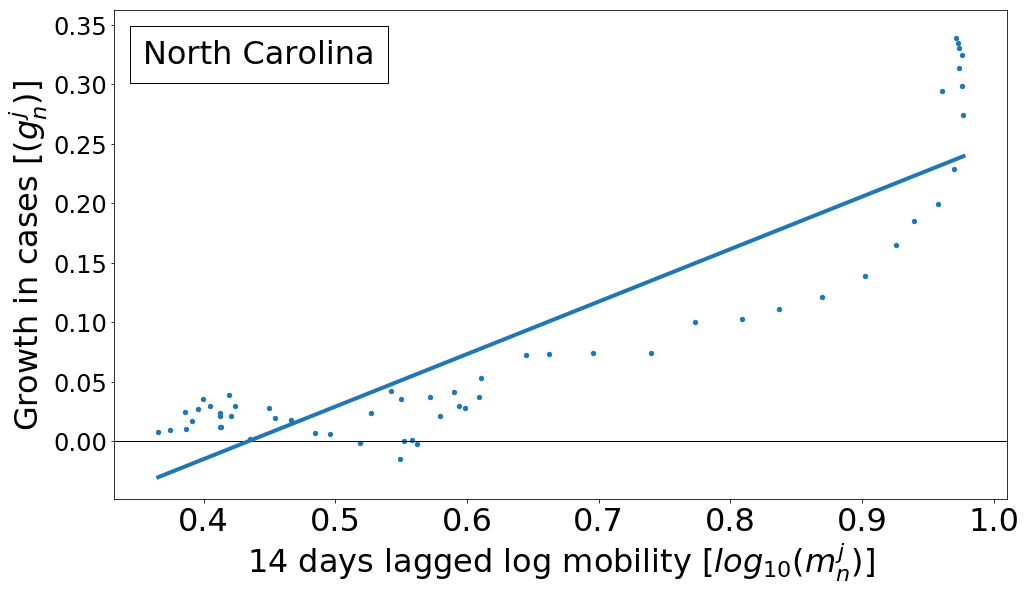

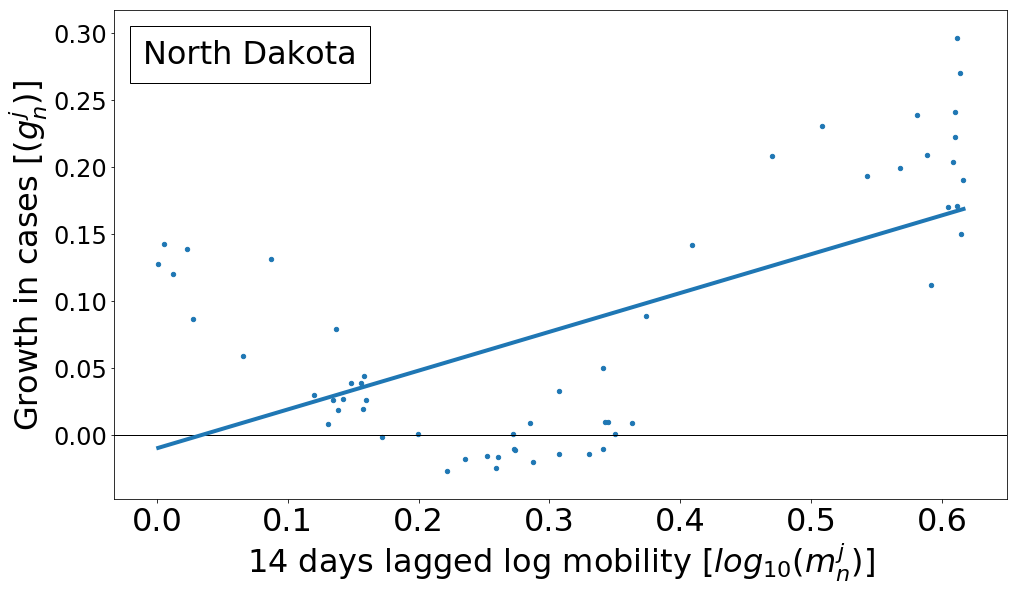

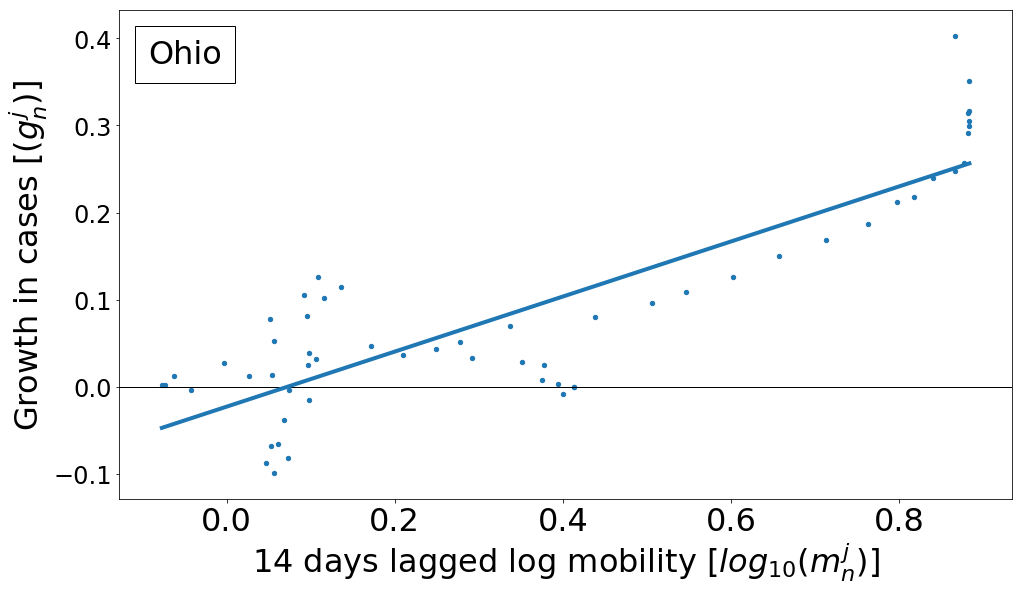

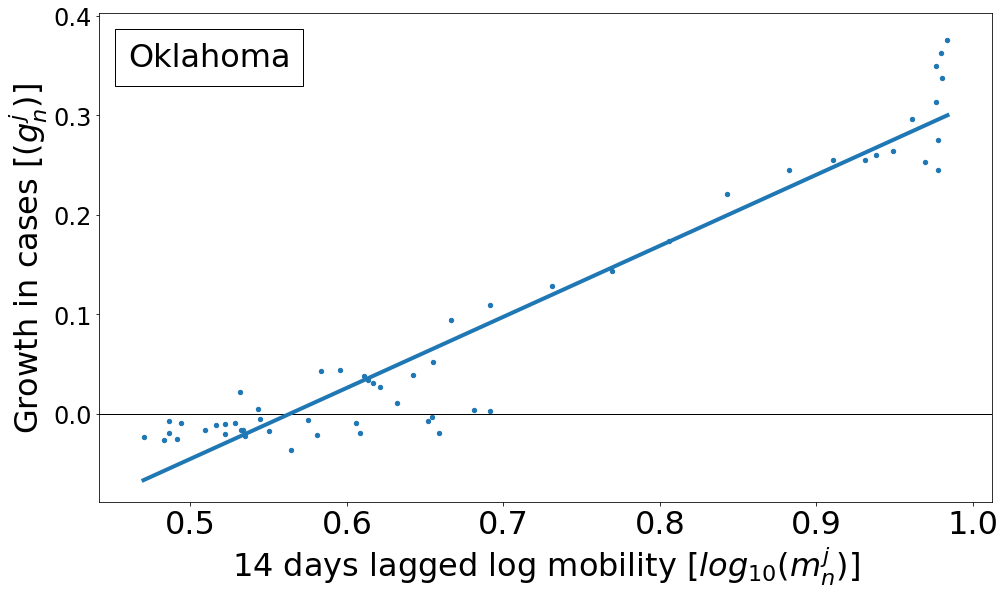

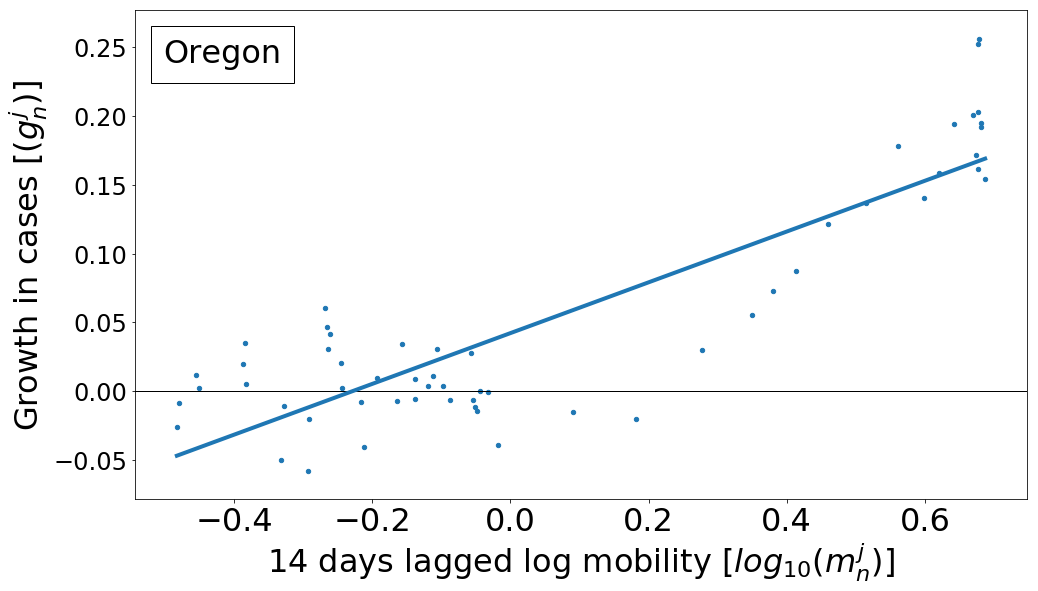

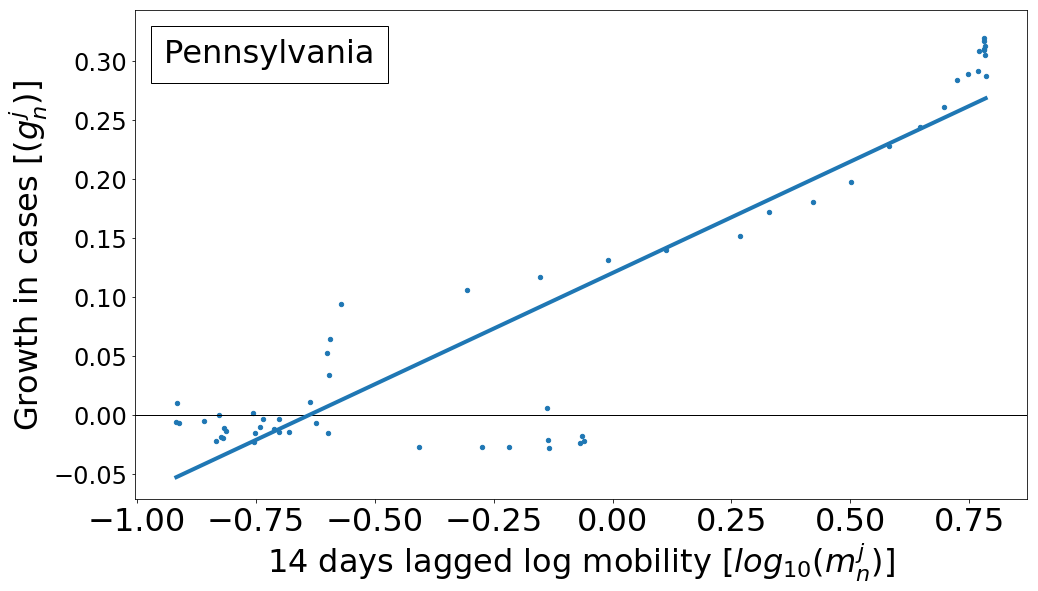

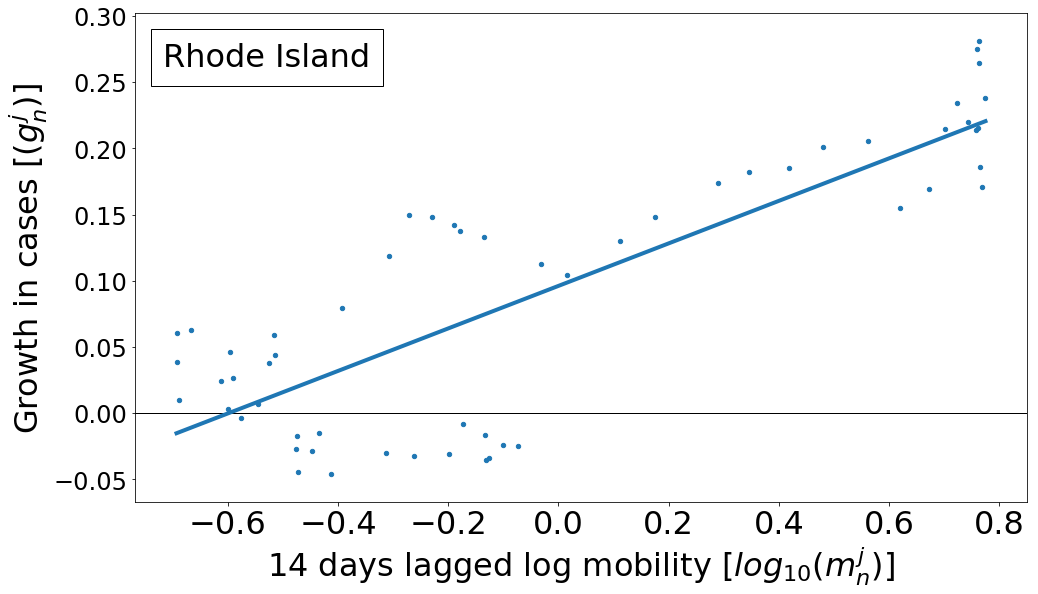

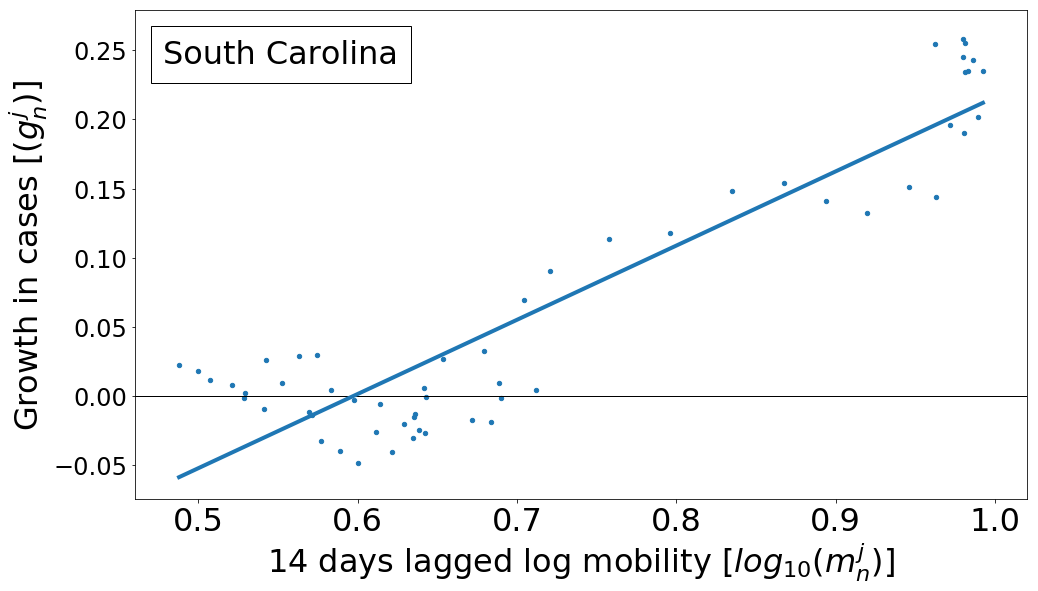

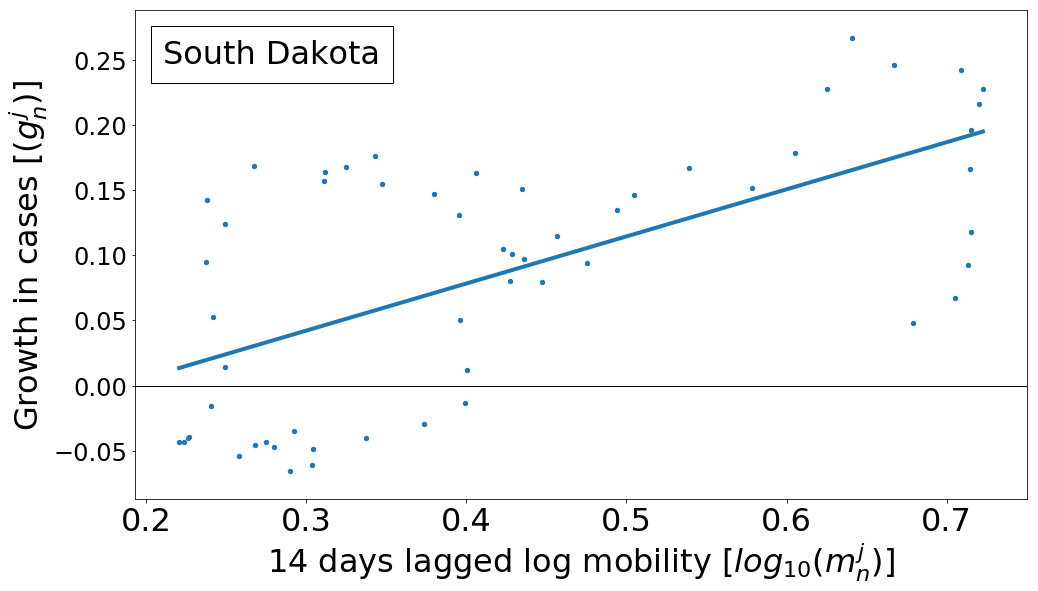

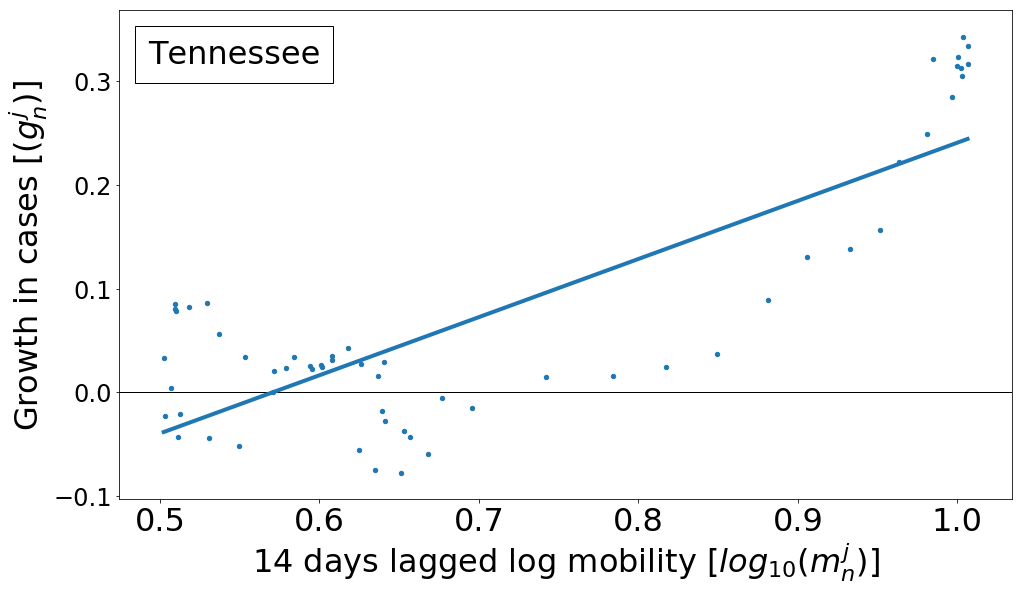

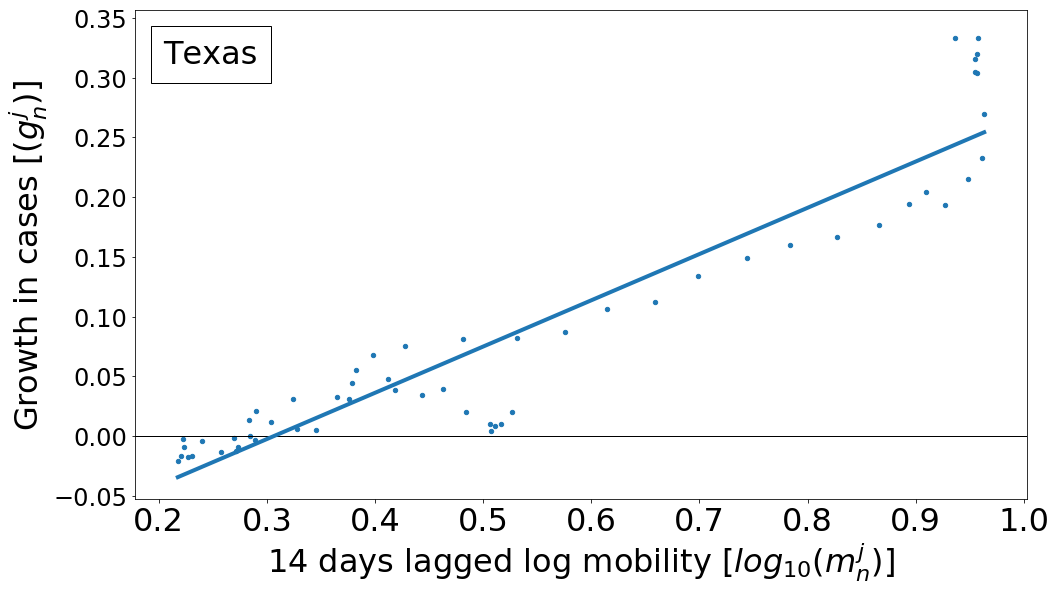

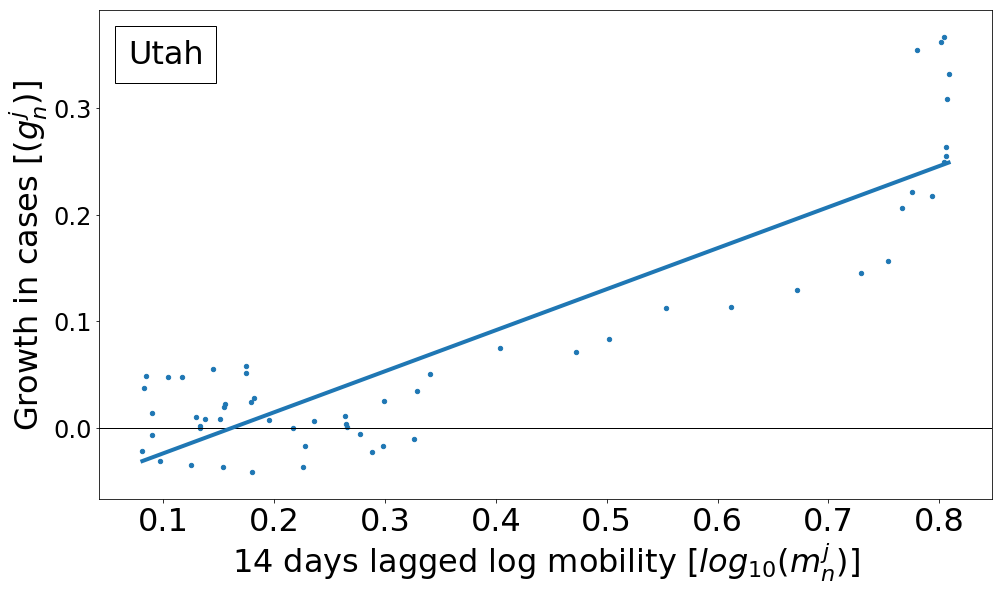

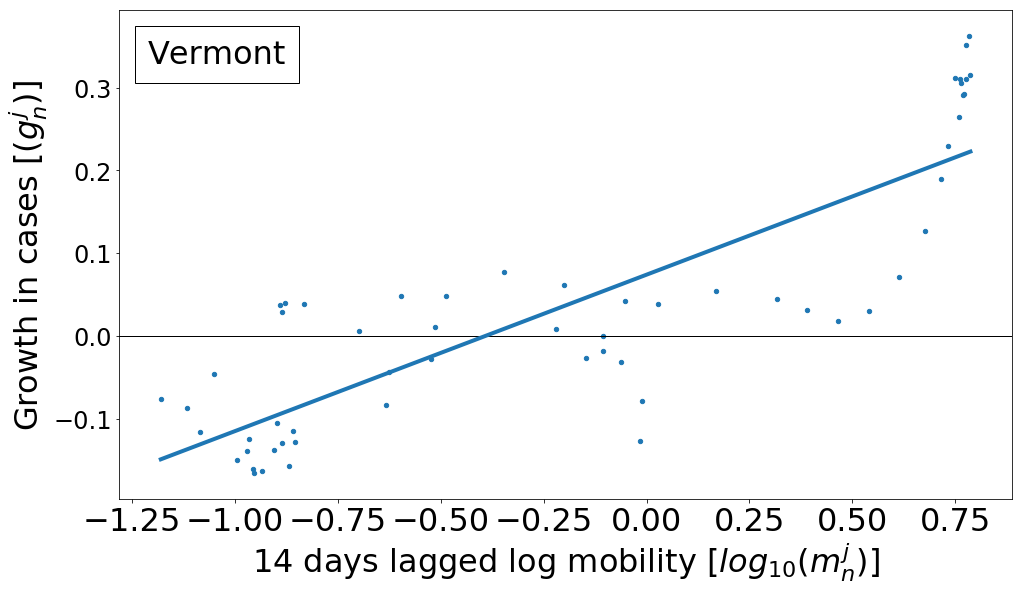

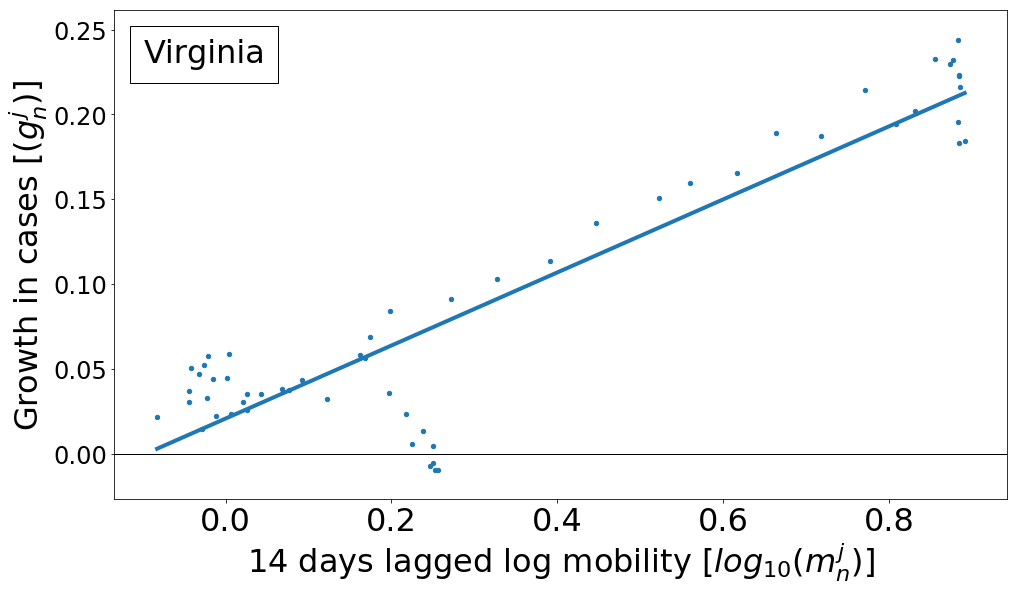

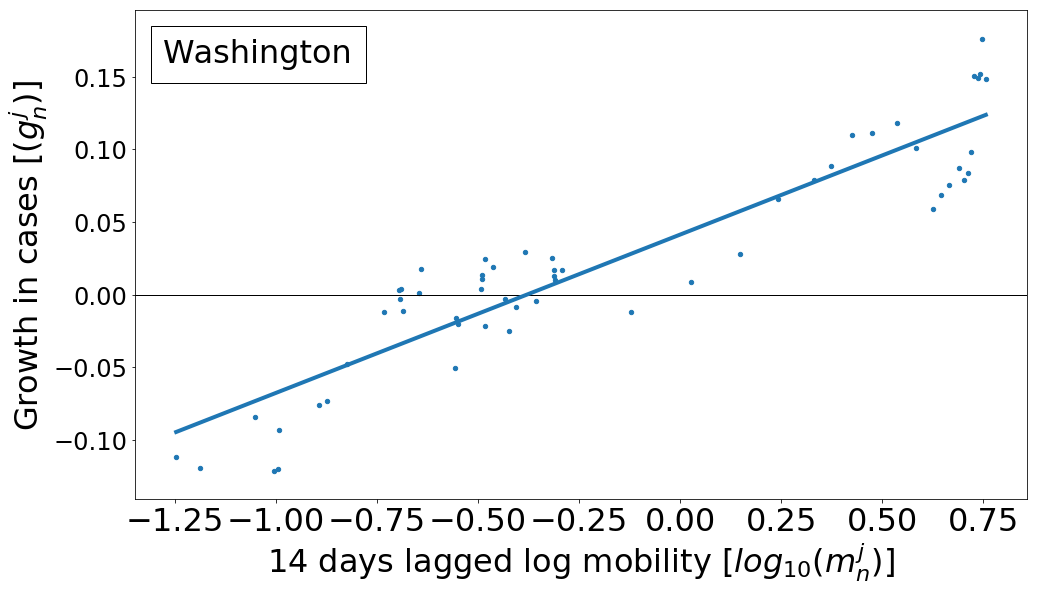

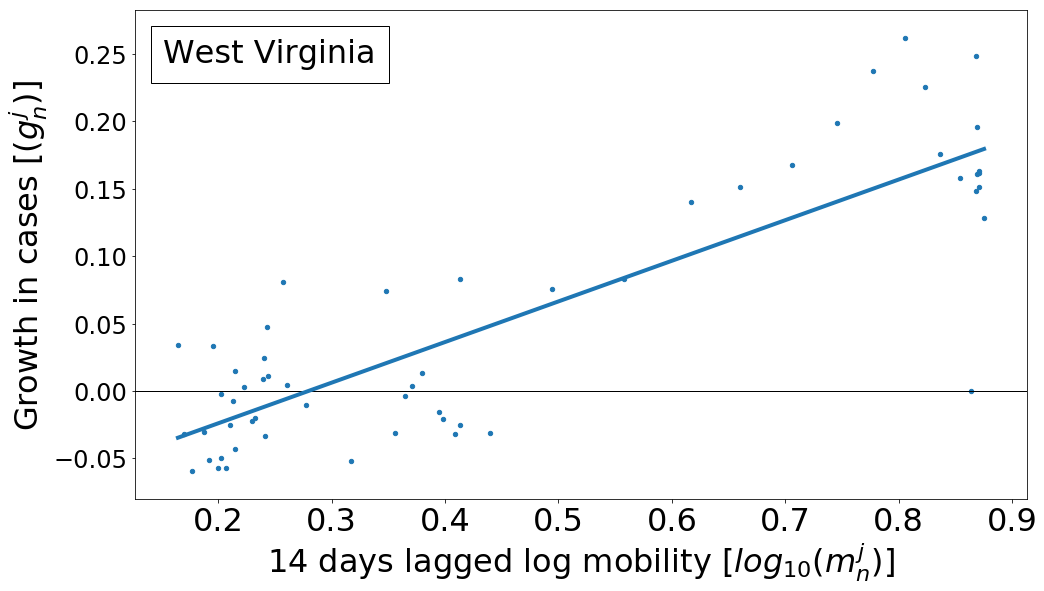

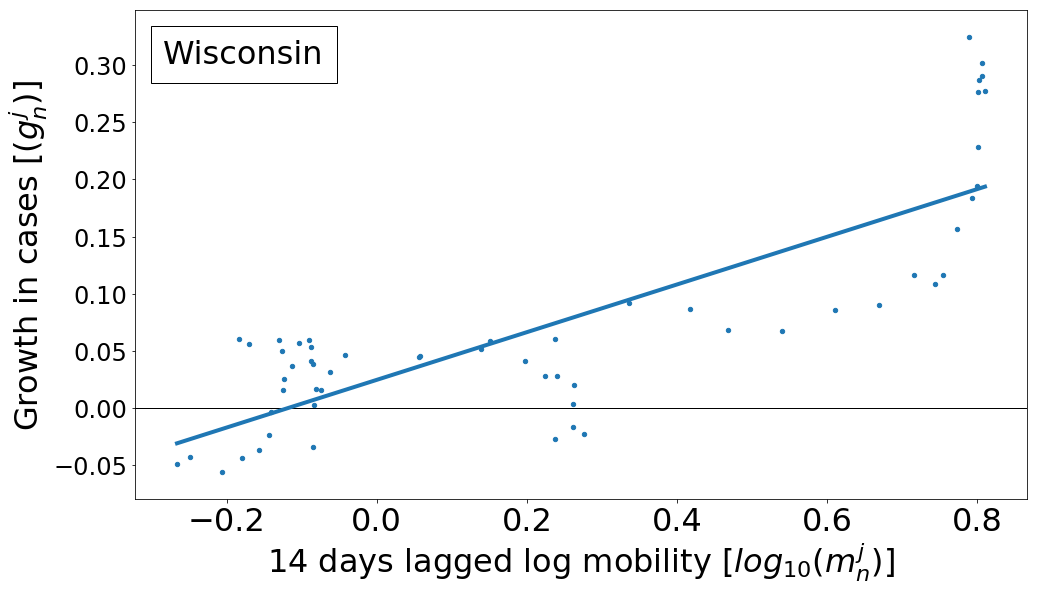

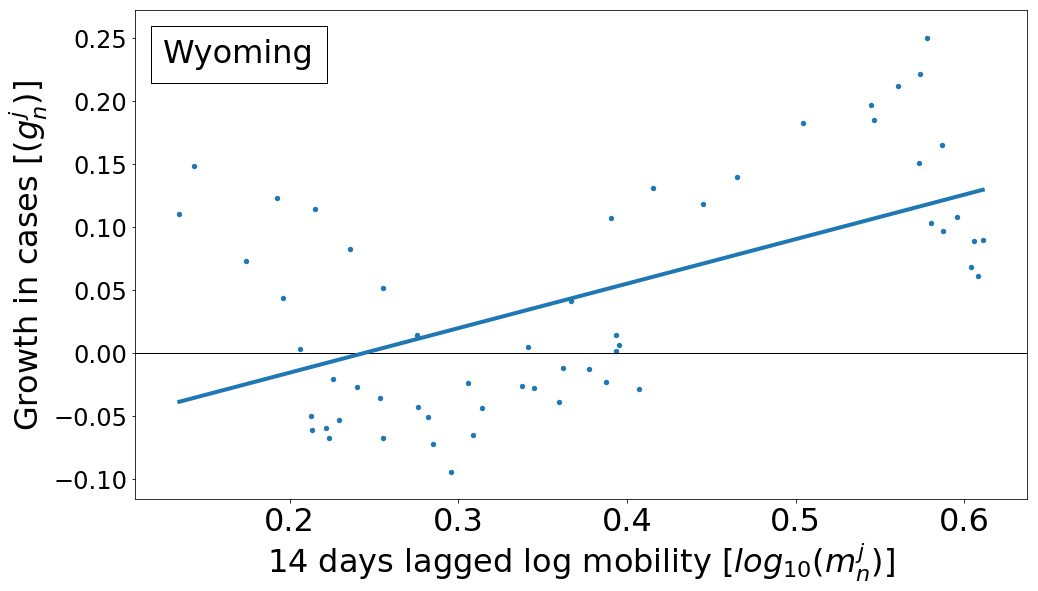

R2         b0         b1    pairs_id  x-intercept
count  51.000000  51.000000  51.000000   51.000000    51.000000
mean    0.687255  -0.048664   0.301787  146.000000    -0.092904
std     0.185139   0.158467   0.166560   14.866069     0.551363
min     0.020000  -0.408490   0.062880  121.000000    -1.882298
25%     0.640000  -0.113757   0.164075  133.500000    -0.386338
50%     0.740000  -0.005818   0.280078  146.000000     0.017496
75%     0.810000   0.057180   0.412934  158.500000     0.278499
max     0.920000   0.176300   0.714351  171.000000     0.699649

In [18]:
# Shutdown Period LogMobility

dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_summary = pandas.DataFrame()

for pairs_id in df_region.sort_values(by='State')['pairs_id'].values:
    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

    df_single = df_plot[pairs_id]
    
    if len(df_single)>0:
        plt.figure(figsize=(16,9))
        ax = plt.subplot(1,1,1)
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], s=19)
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[log_{10}(m^j_n)]$', size=32)
        plt.ylabel('Growth in cases $[(g^j_n)]$', size=32)
        plt.xticks(fontsize=32)
        plt.yticks(fontsize=24)

        try:
            # Linear Regression
            X = df_single['LogMobility']
            X = sm.add_constant(X) #intercept
            y = df_single['GrowthCases']
            model = sm.OLS(y, X)
            results = model.fit()
            #print('Parameters: ', results.params)
            #print('R2: ', results.rsquared)
            b0 = results.params.const
            b1 = results.params.LogMobility
            
            row['b0'] = b0
            row['b1'] = b1
            row['x-intercept'] = -b0/b1
            row['R2'] = numpy.round(results.rsquared, 2)

            x1 = df_single['LogMobility'].min() #-1
            x2 = df_single['LogMobility'].max() #2.5
            plt.plot([x1, x2], [b1*x1+b0, b1*x2+b0], lw=4)

            #anchored_text = AnchoredText(str(numpy.round(b1, 3)) + 'x+' + str(numpy.round(b0, 3))+
            #                             '\nx-intercept '+str(numpy.round(-b0/b1, 2)), loc=2)
            #ax.add_artist(anchored_text)

            anchored_text = AnchoredText(title_string, loc=2, prop=dict(size=32))
            ax.add_artist(anchored_text)

        except: 
            pass

        plt.show()
        
    df_summary = df_summary.append(pandas.DataFrame(row, index=[0]))
df_summary.describe()


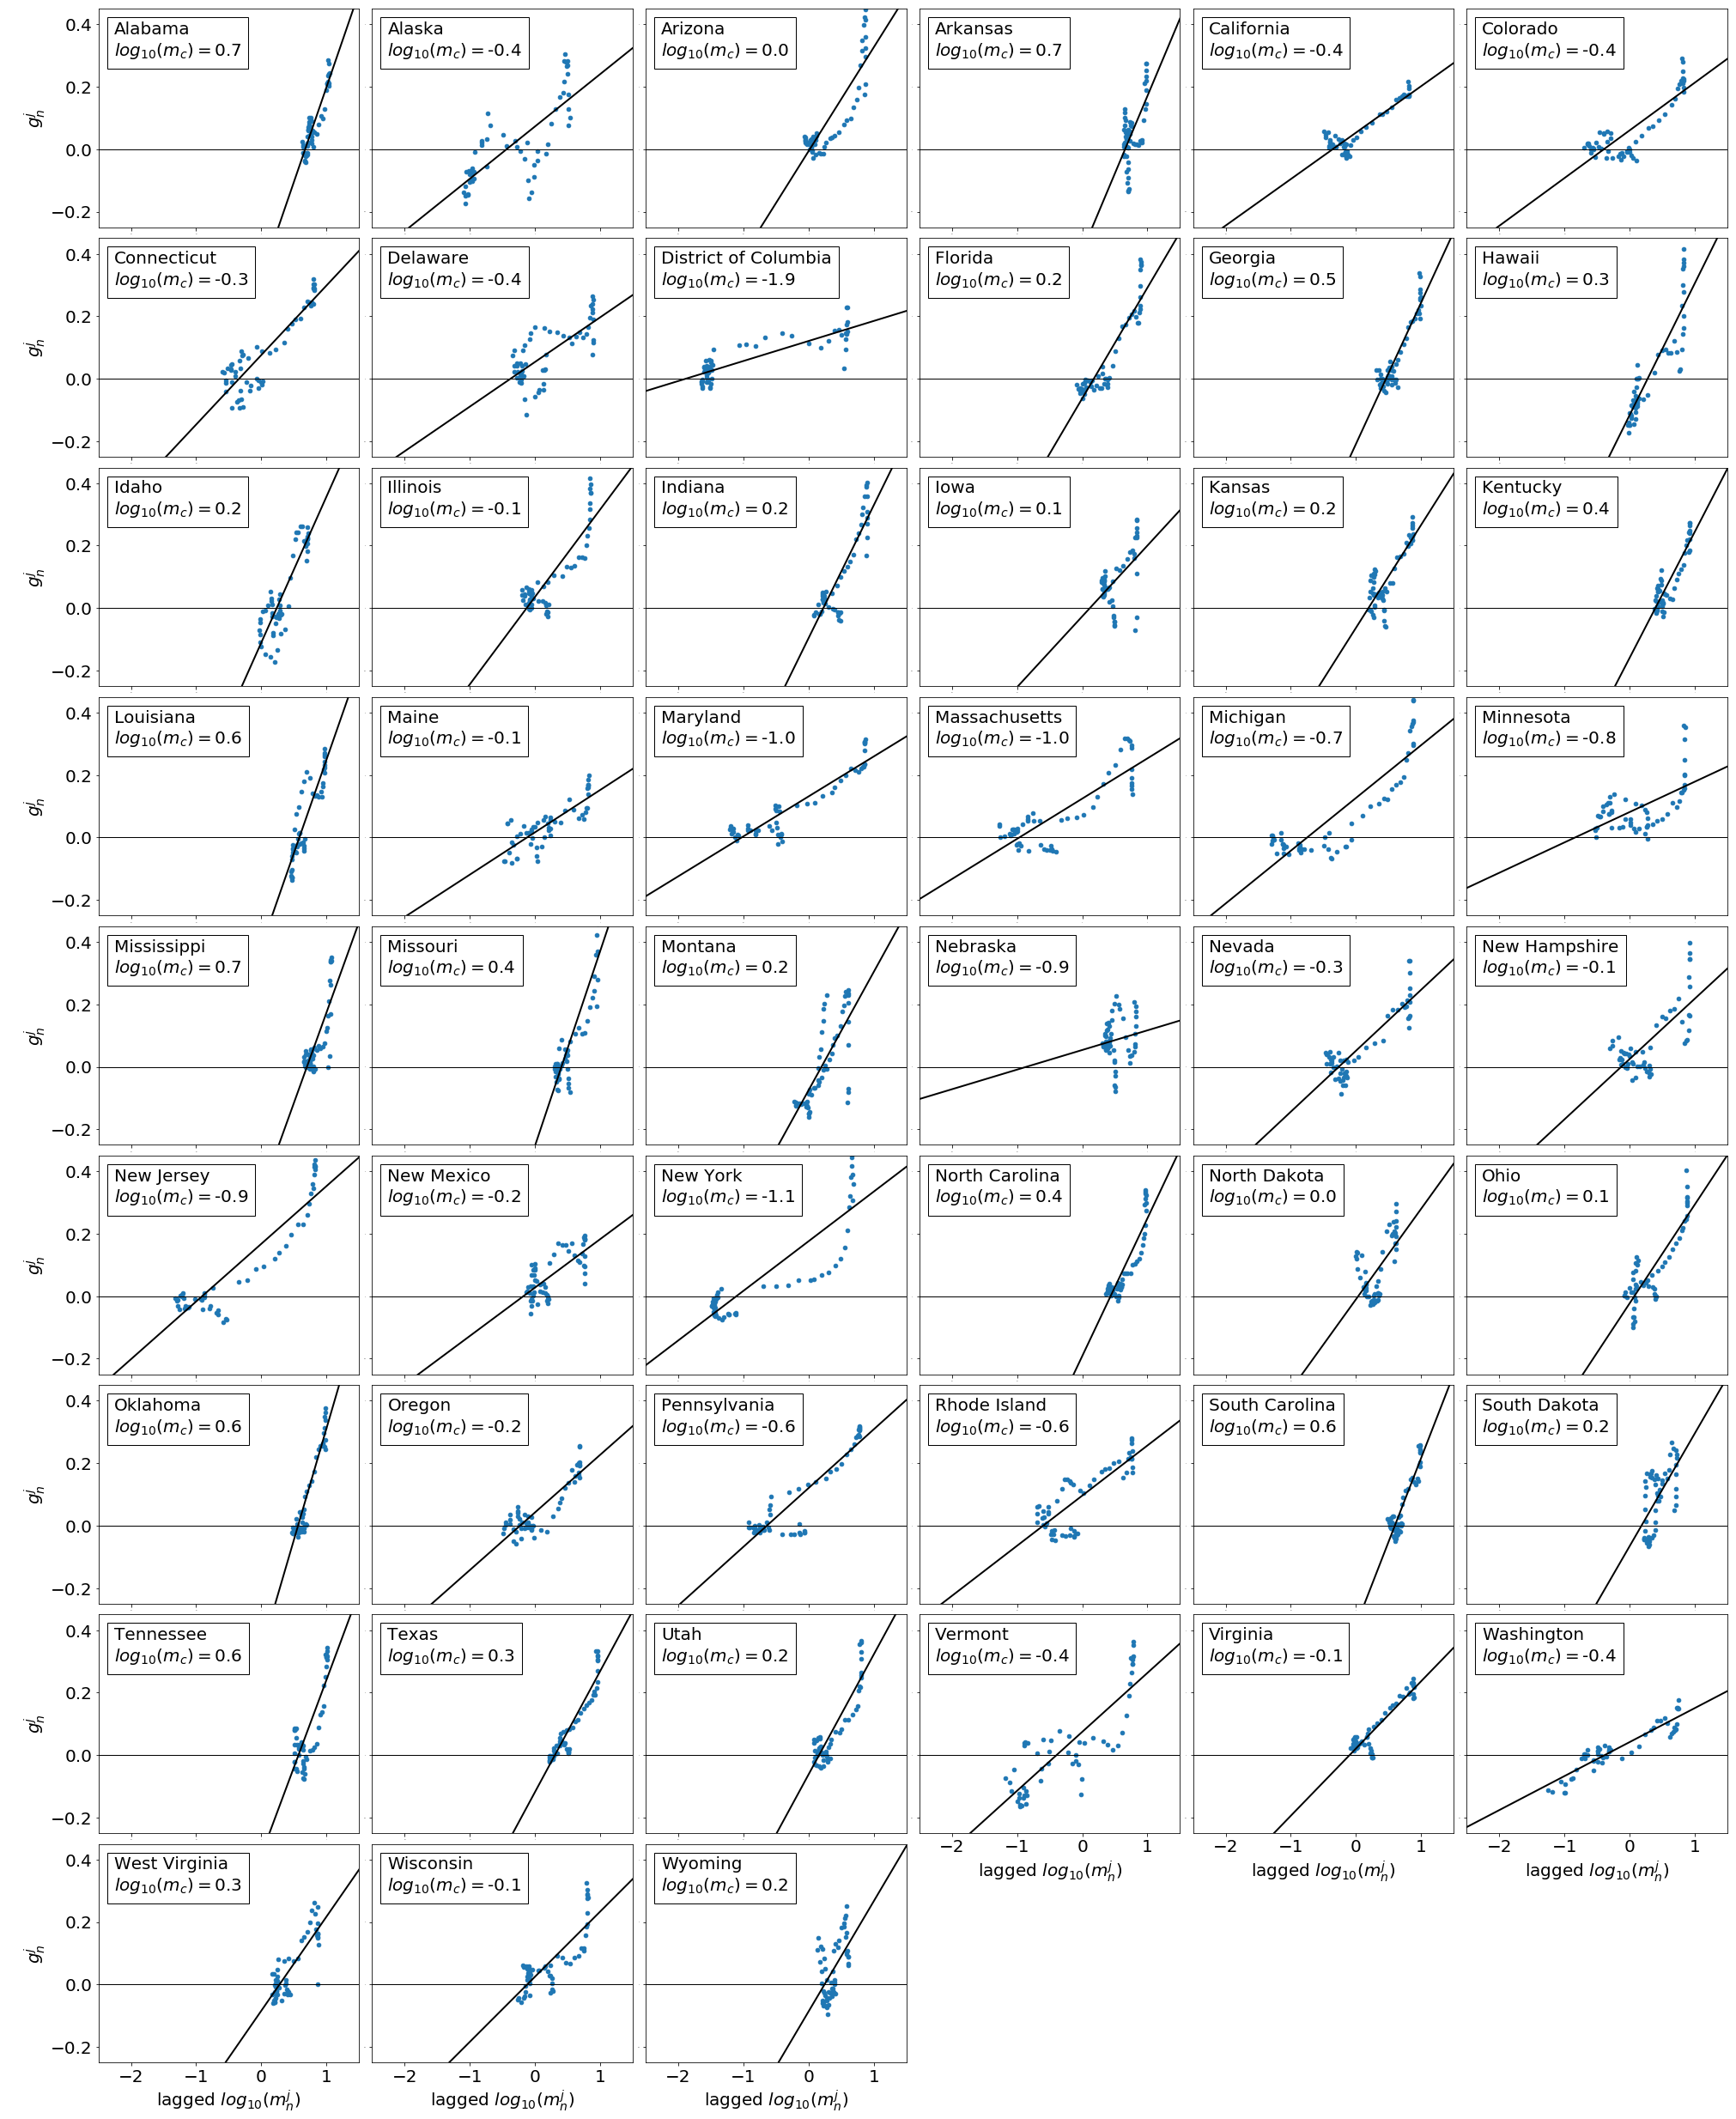

In [19]:
# Shutdown Period LogMobility
dt_cutoff_max = datetime(2020, 4, 30, tzinfo=pytz.utc)
df_plot = df_lagged[df_lagged.index<=dt_cutoff_max]
df_summary = pandas.DataFrame()

fig = plt.figure(figsize=(34, 44)) # letter size 8.5 * 11
fig.subplots_adjust(hspace=0.05, wspace=0.05)

for i, pairs_id in enumerate(df_region.sort_values(by='State')['pairs_id'].values):
    row = {}
    row['pairs_id'] = pairs_id
    row['State'] = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

    df_single = df_plot[pairs_id]
    
    if len(df_single)>0:
        ax = plt.subplot(9, 6,i+1)
        plt.scatter(df_single['LogMobility'], df_single['GrowthCases'], s=21)
        plt.axhline(color='k', lw=1)
        #plt.axvline(color='k', lw=1)

        title_string = df_region[df_region['pairs_id']==pairs_id]['State'].values[0]

        #plt.xlabel(str(cases_lag_measured) + ' days lagged log mobility $[log_{10}(m^j_n)]$', size=12)
        #plt.ylabel('Growth in cases $[(g^j_n)]$', size=12)
        if (i>44):
            plt.xlabel('lagged $log_{10}(m^j_n)$', size=20)
            plt.xticks(fontsize=20)
        else:
            plt.xticks(fontsize=0)
        if (i%6==0):
            plt.ylabel('\n$g^j_n$', size=20)
            plt.yticks(fontsize=20)
        else:
            plt.yticks(fontsize=0)
        #plt.xticks(fontsize=32)
        #plt.yticks(fontsize=24)

        try:
            # Linear Regression
            X = df_single['LogMobility']
            X = sm.add_constant(X) #intercept
            y = df_single['GrowthCases']
            model = sm.OLS(y, X)
            results = model.fit()
            #print('Parameters: ', results.params)
            #print('R2: ', results.rsquared)
            b0 = results.params.const
            b1 = results.params.LogMobility
            
            row['b0'] = b0
            row['b1'] = b1
            row['log_10(m_c)'] = -b0/b1
            row['R2'] = numpy.round(results.rsquared, 2)

            x1 = -2.5 #df_single['LogMobility'].min() #-1
            x2 = 1.5 #df_single['LogMobility'].max() #2.5
            plt.plot([x1, x2], [b1*x1+b0, b1*x2+b0], lw=2, c='k')
            
            ax.locator_params(tight=True, nbins=4)
            
            plt.xlim(xmin=-2.5, xmax=1.5)
            plt.ylim(ymin=-0.25, ymax=0.45)
            
            anchored_text = AnchoredText(title_string + '\n$log_{10}(m_c)=$' + str(numpy.round(row['log_10(m_c)'], 1)), loc=2, prop=dict(size=20))
            ax.add_artist(anchored_text)

            df_summary = df_summary.append(pandas.DataFrame(row, index=[0]))

        except: 
            pass
        

#plt.tight_layout()
plt.savefig(os.path.join(data_subdirectory, 'state_fits_RW14.svg'))
plt.show()

df_summary['R'] = numpy.sqrt(df_summary['R2']) * numpy.sign(df_summary['b1'])
df_summary = numpy.round(df_summary.rename(columns={'b0':'intercept', 'b1':'slope', 'R2':'R-squared'}), 3)

In [20]:
df_summary.describe()

R-squared  intercept      slope  log_10(m_c)    pairs_id          R
count  51.000000  51.000000  51.000000    51.000000   51.000000  51.000000
mean    0.687255  -0.048725   0.301843    -0.092882  146.000000   0.816941
std     0.185139   0.158379   0.166558     0.551384   14.866069   0.142021
min     0.020000  -0.408000   0.063000    -1.882000  121.000000   0.141000
25%     0.640000  -0.113500   0.164500    -0.386000  133.500000   0.799500
50%     0.740000  -0.006000   0.280000     0.017000  146.000000   0.860000
75%     0.810000   0.057000   0.413000     0.278500  158.500000   0.900000
max     0.920000   0.176000   0.714000     0.700000  171.000000   0.959000

In [21]:
# Log scale correlation
numpy.round(df_summary[['slope', 'R']].describe().T, 3)

count   mean    std    min    25%   50%    75%    max
slope   51.0  0.302  0.167  0.063  0.164  0.28  0.413  0.714
R       51.0  0.817  0.142  0.141  0.800  0.86  0.900  0.959

In [22]:
cols = ['State', 'R', 'slope', 'log_10(m_c)']
df_summary[cols].to_csv(os.path.join(data_subdirectory, 'state_fits_RW14_summary.csv'), index=False)
df_summary[cols].set_index('State')

R  slope  log_10(m_c)
State                                          
Alabama               0.927  0.608        0.672
Alaska                0.762  0.168       -0.436
Arizona               0.872  0.333        0.017
Arkansas              0.632  0.497        0.657
California            0.911  0.149       -0.357
Colorado              0.843  0.153       -0.395
Connecticut           0.894  0.223       -0.340
Delaware              0.728  0.143       -0.374
District of Columbia  0.849  0.064       -1.882
Florida               0.911  0.354        0.178
Georgia               0.922  0.453        0.463
Hawaii                0.889  0.422        0.277
Idaho                 0.877  0.468        0.236
Illinois              0.860  0.280       -0.127
Indiana               0.877  0.426        0.226
Iowa                  0.539  0.227        0.117
Kansas                0.825  0.330        0.193
Kentucky              0.900  0.404        0.396
Louisiana             0.900  0.599        0.584
Maine                 0.819  0.136       -0.121
Maryland              0.922  0.128       -1.028
Massachusetts         0.843  0.129       -0.966
Michigan              0.860  0.169       -0.747
Minnesota             0.583  0.097       -0.835
Mississippi           0.787  0.579        0.700
Missouri              0.900  0.624        0.406
Montana               0.748  0.379        0.197
Nebraska              0.141  0.063       -0.858
Nevada                0.877  0.195       -0.263
New Hampshire         0.721  0.193       -0.128
New Jersey            0.911  0.185       -0.909
New Mexico            0.721  0.155       -0.178
New York              0.877  0.159       -1.109
North Carolina        0.894  0.441        0.434
North Dakota          0.608  0.290        0.035
Ohio                  0.854  0.316        0.073
Oklahoma              0.959  0.714        0.564
Oregon                0.872  0.185       -0.228
Pennsylvania          0.911  0.188       -0.640
Rhode Island          0.819  0.161       -0.599
South Carolina        0.917  0.537        0.598
South Dakota          0.624  0.361        0.183
Tennessee             0.819  0.561        0.570
Texas                 0.943  0.387        0.307
Utah                  0.894  0.384        0.161
Vermont               0.843  0.189       -0.393
Virginia              0.917  0.216       -0.096
Washington            0.922  0.109       -0.379
West Virginia         0.854  0.301        0.280
Wisconsin             0.812  0.209       -0.118
Wyoming               0.574  0.353        0.245